In [894]:
%matplotlib inline
%load_ext autoreload
%autoreload

# these are all standard Python modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

# this is my notebookfns.py file
import notebookfns as n
    
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('lines', linewidth=3)
plt.rc('axes', linewidth=3)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def grab_trajectory(traj, params, dataset):
    koop_states = []
    omegas = []
    coords = rings.shape[2]
    half_coords = int(coords/2)

    pred_dyn_states = np.zeros((NNs, num_steps+1, coords))
    x_pred = np.zeros((NNs, num_steps+1, half_coords))
    y_pred = np.zeros((NNs, num_steps+1, half_coords))

    val_dyn_states = X_stacked[:,traj,:]
    x_val = val_dyn_states[:,0:half_coords]
    y_val = val_dyn_states[:,half_coords:]
    t = deltat*range(num_steps+1)

    for didx, data in enumerate(dataset):
        prms = params[didx]
        koop_dim = prms['num_evals']
        sh = (num_steps, koop_dim)

        koop_states.append(np.zeros(sh))
        omegas.append(np.zeros(sh))

        koop_states[idx] = yk_hist[idx][:,traj,:]
        omegas[idx] = omega_hist[idx][:,traj,:]

        pred_dyn_states[idx,:,:] = long_pred[idx][:,traj,:]
        x_pred[idx,:,:] = pred_dyn_states[idx][:,0:half_coords]
        y_pred[idx,:,:] = pred_dyn_states[idx][:,half_coords:]
        
    return t, x_pred, y_pred, x_val, y_val, koop_states, omegas


def build_dataset(option, trajlist, sources):
    # Goes through a list of data files and assembles time histories for the appropriate trajectories.
    # These data files may come from ODE solvers or neural net predictions
    
    if option=='TVT': # Training, Validation, Testing data
        for sidx, src in enumerate(sources):
            # Open the source and read it into memory

            x_preds = []*NTs
            y_preds = []*NTs
            x_vals = []*NTs
            y_vals = []*NTs
            koop_statess = []*NTs
            omegass = []*NTs

            for tr, traj in enumerate(trajlist):
                # Grab only these trajectories for the dataset
                x_preds.append([])
                y_preds.append([])
                x_vals.append([])
                y_vals.append([])
                koop_statess.append([])
                omegass.append([])

                t, x_preds[tr], y_preds[tr], x_vals[tr], y_vals[tr], koop_statess[tr], omegass[tr] = grab_trajectory(traj)
        
    elif option=='NN prediction': # NN prediction data
        return
    
    return dataset


def load_params(sources):
    params = []
    for src in sources:
        with open(src, 'rb') as f:
            params.append(pickle.load(f, encoding='latin1'))

    return params


def collapse_params(prms):
    if 'dynsys_params' in prms.keys():
        params = {**prms['dynsys_params'], **prms['NN_params']}
    else:
        params = prms
    
    return params


def save_dataset(option, dataset):
    if option=='NN prediction':
        print("Saving NN prediction...")
        
        
    print("Done saving.")
    return


In [28]:
from scipy.fft import fft, fftfreq
from scipy.signal import blackman

def ExtractFFT(N, T, y1, y2, x1, x2):
    t = np.linspace(0.0, N*T, N, endpoint=False)
    tf = fftfreq(N, T)[:N//2]

    w = blackman(N)
    
    yf1 = np.zeros(y1.shape)
    yf2 = np.zeros(y1.shape)
    ywf1 = np.zeros(y1.shape)
    ywf2 = np.zeros(y1.shape)
    
    xf1 = np.zeros(y1.shape)
    xf2 = np.zeros(y1.shape)
    xwf1 = np.zeros(y1.shape)
    xwf2 = np.zeros(y1.shape)
    
    for k in range(y1.shape[1]):
        y_v = y1[:,k]
        y_p = y2[:,k]
        x_v = x1[:,k]
        x_p = x2[:,k]
        
        yf1[:,k] = fft(y_v)
        yf2[:,k] = fft(y_p)
        #ywf1[:,k] = fft(y_v*w)
        #ywf2[:,k] = fft(y_p*w)

        xf1[:,k] = fft(x_v)
        xf2[:,k] = fft(x_p)
        #xwf1[:,k] = fft(x_v*w)
        #xwf2[:,k] = fft(x_p*w)
    
    return tf, yf1, ywf1, yf2, ywf2, xf1, xwf1, xf2, xwf2
    
def PlotFFT(tf, N, yf1, ywf1, yf2, ywf2, xf1, xwf1, xf2, xwf2):
    fig, ax = plt.subplots(2,2,figsize=(15,14))

    ax[0,0].semilogy(tf[1:N//2], 2.0/N * np.abs(yf1[1:N//2]))
    #ax[0,0].semilogy(tf[1:N//2], 2.0/N * np.abs(ywf1[1:N//2]), '-r')
    ax[0,1].semilogy(tf[1:N//2], 2.0/N * np.abs(yf2[1:N//2]))
    #ax[0,1].semilogy(tf[1:N//2], 2.0/N * np.abs(ywf2[1:N//2]), '-r')

    ax[1,0].semilogy(tf[1:N//2], 2.0/N * np.abs(xf1[1:N//2]))
    #ax[1,0].semilogy(tf[1:N//2], 2.0/N * np.abs(xwf1[1:N//2]), '-r')
    ax[1,1].semilogy(tf[1:N//2], 2.0/N * np.abs(xf2[1:N//2]))
    #ax[1,1].semilogy(tf[1:N//2], 2.0/N * np.abs(xwf2[1:N//2]), '-r')

    for axs in ax.flatten():
        axs.grid()
        axs.set_ylabel(r'Amplitude $A$')
        axs.set_xlabel(r'frequency $\omega$')

    ax[0,0].set_title('y coords - Ground Truth')
    ax[0,1].set_title('y coords - Prediction')
    ax[1,0].set_title('x coords - Ground Truth')
    ax[1,1].set_title('x coords - Prediction')
    
    plt.show()
    plt.tight_layout()

In [624]:
def load_NNs(NNlist):
    NNs = [{}]
    params = load_params(NNlist)
    for nidx, prms in enumerate(params):
        prms = collapse_params(prms)
        print(prms)
        NNs[nidx]['file'] = NNlist[nidx]
        NNs[nidx]['params'] = prms
        NNs[nidx]['W'], NNs[nidx]['b'] = n.load_weights_koopman(NNlist[nidx], len(prms['widths'])-1, len(prms['widths_omega_real'])-1, prms['num_real'], prms['num_complex_pairs'])
    
    return NNs


# You can change this filename to point to the pickle file for your model.
# Later code loads the related files (i.e. weights & biases) by changing the end of the filename
NNlist = ['output/80-80-170-liner-manual-w\RMI_2022_07_13_12_56_40_951791_model.pkl']
    
    #'output/80-80-170-newformat\RMI_2022_07_26_14_06_59_082828_model.pkl']
    
    # liner manual high w: 'output/80-80-170-liner-manual-high-w\RMI_2022_07_14_11_38_02_936981_model.pkl']
    
    # liner manual-w: 'output/80-80-170-liner-manual-w\RMI_2022_07_13_12_56_40_951791_model.pkl']
    
    # dbl liner
    #'output/80-80-170-dblliner\RMI_2022_07_08_16_01_17_994355_model.pkl'
    
    # single liner
    #'output/80-80-170-liner/RMI_2022_07_02_05_07_40_669847_model.pkl',
    #      'output/80-80-80-170/RMI_2022_07_02_05_07_40_159083_model.pkl',
    #      'output/80-50-20-170/RMI_2022_07_02_05_07_40_159844_model.pkl',
    #      'output/80-30-30-30-170/RMI_2022_07_02_05_07_40_159415_model.pkl']

#2c eigfs on 10-75 angle data: output/2-80-1-170/RMI_2022_06_28_08_35_03_272899_model.pkl'
#3c eigfs on 10-75 angle data: output/2-80-1-170/RMI_2022_06_28_10_40_40_190375_model.pkl'
#5c eigfs on 10-75 angle data: output/2-87-1-253/RMI_2022_06_28_16_27_32_633224_model.pkl'

#1c egf on 2-75 angle data: /original_arch/1cEigf/RMI_2022_06_09_13_14_56_182592_model.pkl'
#2c eigfs on 2-75 angle data: /original_arch/2cEigf/RMI_2022_06_14_06_31_55_361995_model.pkl'

NNlist = load_NNs(NNlist)
NNs = len(NNlist)

{'id': '80-80-170', 'folder_name': 'output/80-80-170', 'train_data': 'RMI-liner-101-36', 'fixed_omegas': [(-0.01+1j), (-0.011+10j), (-0.0111+100j)], 'num_real': 0, 'num_complex_pairs': 2, 'num_evals': 10, 'widths': array([72, 80, 80, 10, 10, 80, 80, 72]), 'hidden_widths_omega': [170], 'dist_weights': ['dl', 'dl', 'dl', 'dl', 'dl', 'dl', 'dl'], 'dist_weights_omega': ['dl', 'dl'], 'num_shifts': 30, 'num_shifts_middle': 100, 'recon_lam': 0.001, 'Linf_lam': 1e-09, 'L1_lam': 0.0, 'L2_lam': 1e-14, 'auto_first': 1, 'learning_rate': 0.005, 'num_passes_per_file': 4500, 'num_steps_per_batch': 2, 'batch_size': 128, 'num_steps_per_file_pass': 100, 'max_time': 50400.0, 'min_5min': 1, 'min_20min': 1, 'min_40min': 1, 'min_1hr': 1, 'min_2hr': 1, 'min_3hr': 1, 'min_4hr': 1, 'min_halfway': 1, 'config': 'liner', 'data_name': 'RMI', 'len_time': 101, 'delta_t': 0.05, 't': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.

note that these errors include the weights alpha_1, alpha_2, alpha_3
red is training error, blue is validation error


C:\Users\gibson48\Desktop\KoopmanRMI\DeepKoopman-master\DeepKoopman-master\notebookfns.py:19: RuntimeWarning: divide by zero encountered in log10
  errors[:, j] = np.log10(errors[:, j])


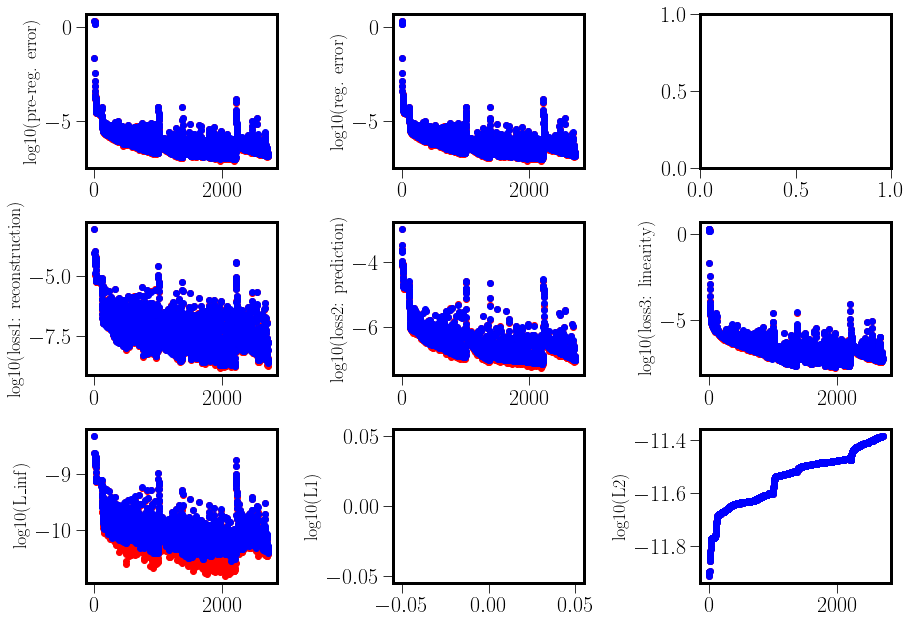

In [625]:
err = []
for idx, nn in enumerate(NNlist):
    fn = nn['file']
    err.append(np.array(np.loadtxt(fn.replace('model.pkl','error.csv'),delimiter=',')))
    n.PlotErrors(err[idx], range(0,16))

In [626]:
for idx, nn in enumerate(NNlist):
    fn = nn['file']
    params = nn['params']
    print('validation error: %.2E' % params['minTest'])

    print('We had %d files of training data.' % params['data_train_len'])
    print('Length of trajectories: %d steps (goes in Table 2)' % params['len_time'])
    print('Batch size: %d (goes in Table 2)' % params['batch_size'])
    deltat = params['delta_t']
    print('delta_t (time stepping in data): %.3f' % deltat)
    T = deltat*(params['len_time']-1)
    tSpan = np.linspace(start=0,stop=T,num=params['len_time'],endpoint=True)
    print("Time span is %r" % tSpan)

    print("For Table 4:")
    print('log10 of alpha_1 (the weight on losses involving reconstruction): %.1f' % np.log10(params['recon_lam']))
    print('log10 of alpha_2 (the weight on L_inf term): %.1f' % np.log10(params['Linf_lam']))
    print('log10 of alpha_3 (the weight on L_2 regularization): %.1f' % np.log10(params['L2_lam']))

    print('The training was allowed to run up to %.1f hours' % (params['max_time']/(60*60)))
    print('The training actually ran for %.1f hours' % (params['time_exp']/(60*60)))
    print('The stop condition was: %s' % params['stop_condition'])

    print('Did we do the autoencoder pre-training? %d' % params['auto_first'])
    print('The learning rate was %.2E' % params['learning_rate'])

    depth = (params['d']-4)/2
    print("For Table 3:")
    print('The encoder and decoder each had %d hidden layers.' % depth)
    print('The widths of the layers of the main network were %r.' % params['widths'])
    print('The aux. network had %d hidden layers.' % len(params['hidden_widths_omega']))
    print('The widths of the hidden layers of the aux. network were %r.' % params['hidden_widths_omega'])

    print('We penalized %d (S_p) steps for prediction. (goes in Table 4)' % params['num_shifts'])
    print('We penalized %d steps in the linearity loss.' %params['num_shifts_middle'])

validation error: 9.46E-08
We had 3 files of training data.
Length of trajectories: 101 steps (goes in Table 2)
Batch size: 128 (goes in Table 2)
delta_t (time stepping in data): 0.050
Time span is array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
       3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
       3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
       4.95, 5.  ])
For Table 4:
log10 of alpha_1 (the weight on losses involving reconstruction): -3.0
log10 of alpha_2 (the weight on L_inf ter

In [627]:
data_num = 0
#fldr = 'data/TVT/RMI-liner-101-36-old/'
fldr = 'data/TVT/RMI-liner-101-36-oldformat/'
#fldr = 'data/TVT/RMI-dblliner-101-72/'
prms_fn = fldr + 'dynsys_params.pkl'
data_fn = fldr + 'RMI_val_x.csv'
data_train_fn = fldr + 'RMI_train1_x.csv'
#data_fn = 'data/TVT/RMI-sine-101-36/RMI_val_x.csv'
dyn_prms = load_params([prms_fn])

# load the validation data
X = np.loadtxt(data_fn,delimiter=',')
X_train = np.loadtxt(data_train_fn,delimiter=',')

# reshape the validation data
params = NNlist[0]['params']
max_shifts_to_stack = n.num_shifts_in_stack(params)
X_stacked, num_traj_val = n.stack_data(X, max_shifts_to_stack, params['len_time'])
X_train_stacked, num_traj_train_val = n.stack_data(X_train, max_shifts_to_stack, params['len_time'])

# Xk is just the initial conditions of each trajectory
Xk = np.squeeze(X_stacked[0,:,:])

In [628]:
for nidx, nn in enumerate(NNlist):
    prms, W, b = n.grab_nn(nn)

    # apply the network to just the initial conditions Xk
    # output the data transformed to y-coordinates (steps k, k+1, k+2, k+3 are steps 0, 1, 2, 3 here)
    # also output the reconstructed Xk and the predictions for three steps
    yk, ykplus1, ykplus2, ykplus3, xk_recon, xkplus1, xkplus2, xkplus3 = n.ApplyKoopmanNetOmegas(prms, Xk, W, b, prms['delta_t'], prms['num_real'], prms['num_complex_pairs'], prms['num_encoder_weights'], prms['num_omega_weights'], prms['num_decoder_weights'])

    # here apply the network to the full dataset
    # output list of predictions y and list of encded data g_list, like in the training code
    y, g_list = n.ApplyKoopmanNetOmegasFull(prms, X_stacked, W, b, prms['delta_t'], prms['num_shifts'], prms['num_shifts_middle'], prms['num_real'], prms['num_complex_pairs'], prms['num_encoder_weights'], prms['num_omega_weights'], prms['num_decoder_weights'])

    # calculate the validation loss, split over the loss components
    loss1_val, loss2_val, loss3_val, loss_Linf_val, loss_val = n.define_loss(X_stacked, y, g_list, prms, W, b)

    print('Reconstruction loss (on validation set): %.4E' % loss1_val)
    print('Prediction loss (on validation set): %.4E' % loss2_val)
    print('Linearity loss (on validation set): %.4E' % loss3_val)
    print('L_inf loss (on validation set): %.4E' % loss_Linf_val)
    print('Pre-regularization loss (on validation set): %.4E (goes in Table 1)' % loss_val)

    loss_L1_val, loss_L2_val, regularized_loss_val = n.define_regularization(prms, W, b, loss_val)
    print('L1 penalty (on weights): %.4E' % loss_L1_val)
    print('L2 penalty (on weights): %.4E' % loss_L2_val)
    print('Total regularized loss (on validation set): %.4E' % regularized_loss_val)

    omegas = n.omega_net_apply(prms, yk, W, b, prms['num_omega_weights'])

    # The auxiliary network outputs the parameters for the eigenvalues in the K matrix.
    # For each pair of complex conjugate eigenvalues, the continuous time version would be lambda = mu +/- i omega
    # The discrete time version is exp(lambda delta t) 
    # By Euler's formula, can also write this as exp(mu deltat) * (cos(omega deltat) + i sin(omega deltat))
    # The auxiliary network outputs mu and omega
    print('Omega ranges from %.3f to %.3f (corresponding to changing frequencies)' % (np.min(omegas[0][:,0]), np.max(omegas[0][:,0])))
    print('Mu ranges from %.6f to %.6f (so there is almost no growth or decay)' % (np.min(omegas[0][:,1]), np.max(omegas[0][:,1])))
    print('Recall: delta_t = %.2f' % deltat)

    print('To set axis ticks on next two figures:')
    print('The first y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,0]), np.max(yk[:,0])))
    print('The second y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,1]), np.max(yk[:,1])))

    print('Reconstruction error on initial conditions: %.2E' % np.mean(np.square(Xk - xk_recon)))
    print('1-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:]))))
    print('2-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:]))))

    print('Relative reconstruction error on initial conditions: %.2E' % (np.mean(np.square(Xk - xk_recon))/np.mean(np.square(Xk))))
    print('Relative 1-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:])))/np.mean(np.square(np.squeeze(X_stacked[1,:,:])))))
    print('Relative 2-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:])))/np.mean(np.square(np.squeeze(X_stacked[2,:,:])))))

Reconstruction loss (on validation set): 1.7786E-09
Prediction loss (on validation set): 7.1780E-08
Linearity loss (on validation set): 1.8309E-08
L_inf loss (on validation set): 3.9184E-11
Pre-regularization loss (on validation set): 9.1907E-08 (goes in Table 1)
L1 penalty (on weights): 0.0000E+00
L2 penalty (on weights): 3.3930E-12
Total regularized loss (on validation set): 9.1910E-08
Omega ranges from -0.000 to 0.000 (corresponding to changing frequencies)
Mu ranges from -0.402027 to -0.400857 (so there is almost no growth or decay)
Recall: delta_t = 0.05
To set axis ticks on next two figures:
The first y coordinate ranges from 0.034 to 0.051.
The second y coordinate ranges from -0.001 to -0.001.
Reconstruction error on initial conditions: 1.78E-06
1-step prediction error on initial conditions: 3.38E-06
2-step prediction error on initial conditions: 9.94E-06
Relative reconstruction error on initial conditions: 1.80E-06
Relative 1-step prediction error on initial conditions: 3.41E-0

In [629]:
def NN_predict(NNs, datasets):
    # provided dataset structure: [M]x[T,K,P]
    # returned structre: [N,M]x[T,K,P]
    
    # N neural nets and M datasets (must be TVTs: Training-Validation-Test type)
    # T time-steps, K is the number of trajectories, and P the number of coordinates/components of motion.

    # Use the listed NNs to predict on the given dataset.
    cyc = 1 # Number of times to cycle through and continue the prediction
    tMult = 1 # Time multiplier.

    N = len(NNs)
    M = len(datasets)
    
    koop_states = np.empty((N,M),dtype='object')
    omega_hist = np.empty((N,M),dtype='object')
    long_pred = np.empty((N,M),dtype='object')

    print('%s neural nets predicting on %s dataset(s)' % (len(NNs), len(datasets)))
    for nidx, nn in enumerate(NNs):
        prms, W, b = n.grab_nn(nn)
        print('Predicting NN %s: %s' % (nidx+1, prms['id']))
        
        for didx, data in enumerate(datasets):
            T = data.shape[0]
            K = data.shape[1]
            P = data.shape[2]
            
            koop_dim = prms['num_evals']
            num_steps = prms['len_time']
            sh = (num_steps, K, koop_dim)
            sh2 = (num_steps+1, K, P)

            koop_states[nidx,didx] = np.zeros(sh)
            omega_hist[nidx,didx] = np.zeros(sh)
            long_pred[nidx,didx] = np.zeros(sh2)

            # Grab the first initial conditions. Later ICs will continue from where it left off in the cycle.
            ic = np.zeros((K,P))
            for j in np.arange(K):
                ic[j] = np.squeeze(data[0,j,:])

            # Broken down this way because the data just gets too big if done in a single chunk. Can't handle it.
            for cy in range(cyc):
                for j in np.arange(K):
                    long_pred[nidx,didx][0,j,:] = ic[j]
                    long_pred[nidx,didx][1:,j,:], koop_states[nidx,didx][:,j,:], omega_hist[nidx,didx][:,j,:] = n.PredictKoopmanNetOmegas(ic[j], nn, num_steps)

                    # set new ICs for next loop:
                    ic[j] = long_pred[nidx,didx][-1,j,:]

    print('Done predicting')
    return long_pred, koop_states, omega_hist

In [630]:
# Apply networks to the dataset, but this for many steps
# Uses only network initial condition of each trajectory.
dyn_states, koop_states, omegas = NN_predict(NNlist, [X_stacked])
data = [dyn_states, koop_states, omegas]

# Save the dataset
#save_dataset('NN prediction', data)

1 neural nets predicting on 1 dataset(s)
Predicting NN 1: 80-80-170
Done predicting


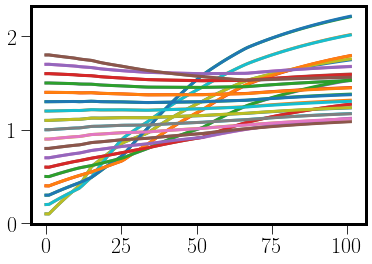

In [631]:
x_sts = dyn_states[0,0][:,0,0:36]
y_sts = dyn_states[0,0][:,0,36:72]
gs = dyn_states[0,0][:,0,72:108]

fig = plt.plot(x_sts)

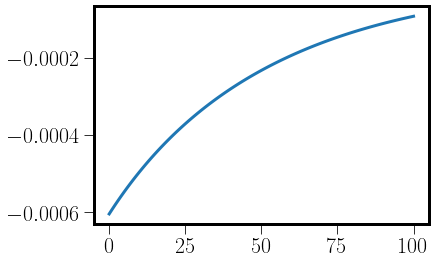

In [632]:
ks = koop_states[0,0][:,0,:]

plt.plot(ks[:,1])

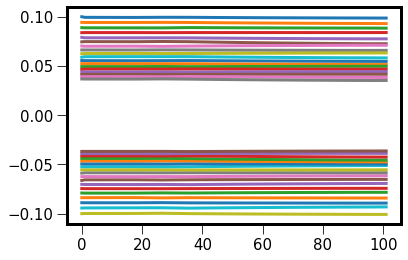

In [17]:
fig = plt.plot(gs)

In [790]:
def time_series(ic, target, num_steps, option='linear', aux=''):
    idt = np.ones(num_steps)
    ts = [0]*num_steps
    t = np.arange(num_steps)
    
    if option=='linear':
        new_slps = (target - ic)/num_steps
        ts = np.transpose(np.outer(new_slps, t) + np.outer(ics,idt))
        
    elif option=='exp':
        if aux: d = aux
        else: d = np.ln((ic/target)^(1/num_steps))

        ts = ic*np.exp(-d * t)

    return ts

def reweave(x):
    x_new = np.hstack([x[:,0::2], x[:,1::2]])
    
    return x_new


def plot_Koopman_states(ks, ts=0, kidx=[0], color_scheme='blank', animate='off'):
    re_o = ks[:,1::2]
    im_o = ks[:,0::2]
    T = len(ts)
    baron = 0
    cbar = ''

    if color_scheme=='blank':
        colors = 'blue'
    elif color_scheme=='progressive_hue':
        baron = 1
        colors = np.repeat(np.floor(np.linspace(0,1,T)*100).astype('int32'), re_o.shape[1], axis=0)
        cbar='viridis'
    
    if animate=='off':
        a_loop = [0]
    else:
        a_loop = range(animate)
        
    for k in a_loop:
        plt.scatter(re_o[ts,:], im_o[ts,:], c=colors, cmap=cbar)
        if baron==1: plt.colorbar()
        plt.show()

        
def animate_Koopman_states(ks, ts, kidx=[0]):
    cs = 'progressive_hue'
    T = range(ts)
    for t in T:
        plot_Koopman_states(ks, range(t), kidx, cs)


trajlist = [7,30]
traj = trajlist[0]
ks = np.copy(koop_states[0,0][:,traj,:])

t = np.arange(101)
st = [(1)*np.sin(t*(2*np.pi/5))]*4
st = np.transpose(np.stack(st))


#ks[:,3] -= 0.1
ics = ks[0,:]
og_ends = ks[-1,:]

new_ends1 = og_ends + 0.05
new_ends1[1] = og_ends[1] + 0.001
new_ends2 = og_ends + 0.06
new_ends2[3] = og_ends[3] + 0.001

# SQUASH THE JET!
dec_K_TS = n.decode_Koopman_TS(ks, NNlist[0])
do_ends = dec_K_TS[-1,:]
do_ends[0:6] = do_ends[17]
do_ends[18:24] = do_ends[31]

koop_target_ends = n.encode_Koopman_TS(do_ends[np.newaxis, :], NNlist[0])

new_ks = time_series(ics, koop_target_ends, len(t))

new_ks1 = np.copy(ks)
new_ks2 = np.copy(ks)

temp_ks1 = time_series(ics, new_ends1, len(t))
temp_ks2 = time_series(ics, new_ends2, len(t))

idx = [0,1]
new_ks1[:,idx] = temp_ks1[:,idx]
idx = [2,3]
new_ks2[:,idx] = temp_ks2[:,idx]

#plot_Koopman_states(ks, range(101), [0], 'progressive_hue')
#plot_Koopman_states(new_ks1, range(101), [1], 'progressive_hue')
#plot_Koopman_states(new_ks2, range(101), [1], 'progressive_hue')

dec_K_TS0 = n.decode_Koopman_TS(ks, NNlist[0])
dec_K_TS0star = n.decode_Koopman_TS(new_ks, NNlist[0])
dec_K_TS1 = n.decode_Koopman_TS(new_ks1, NNlist[0])
dec_K_TS2 = n.decode_Koopman_TS(new_ks2, NNlist[0])

rks = reweave(ks)
rkstar = reweave(new_ks)
rks1 = reweave(new_ks1)
rks2 = reweave(new_ks2)

K_TS = []
K_TS.append(rks)
K_TS.append(rkstar)
K_TS.append(rks1)
K_TS.append(rks2)
K_TS = np.transpose(np.stack(K_TS), (1,0,2))

dyn_sts = []
dyn_sts.append(dec_K_TS0)
dyn_sts.append(dec_K_TS0star)
dyn_sts.append(dec_K_TS1)
dyn_sts.append(dec_K_TS2)
dyn_sts = np.transpose(np.stack(dyn_sts), (1,0,2))

[ 6.83903581e-03 -1.11684148e-04  5.21831760e-02 -3.97632830e-04
 -2.63074112e-05  8.62468690e-06 -2.80199367e-05 -2.54749345e-05
  5.20370911e-06 -1.39014748e-05]


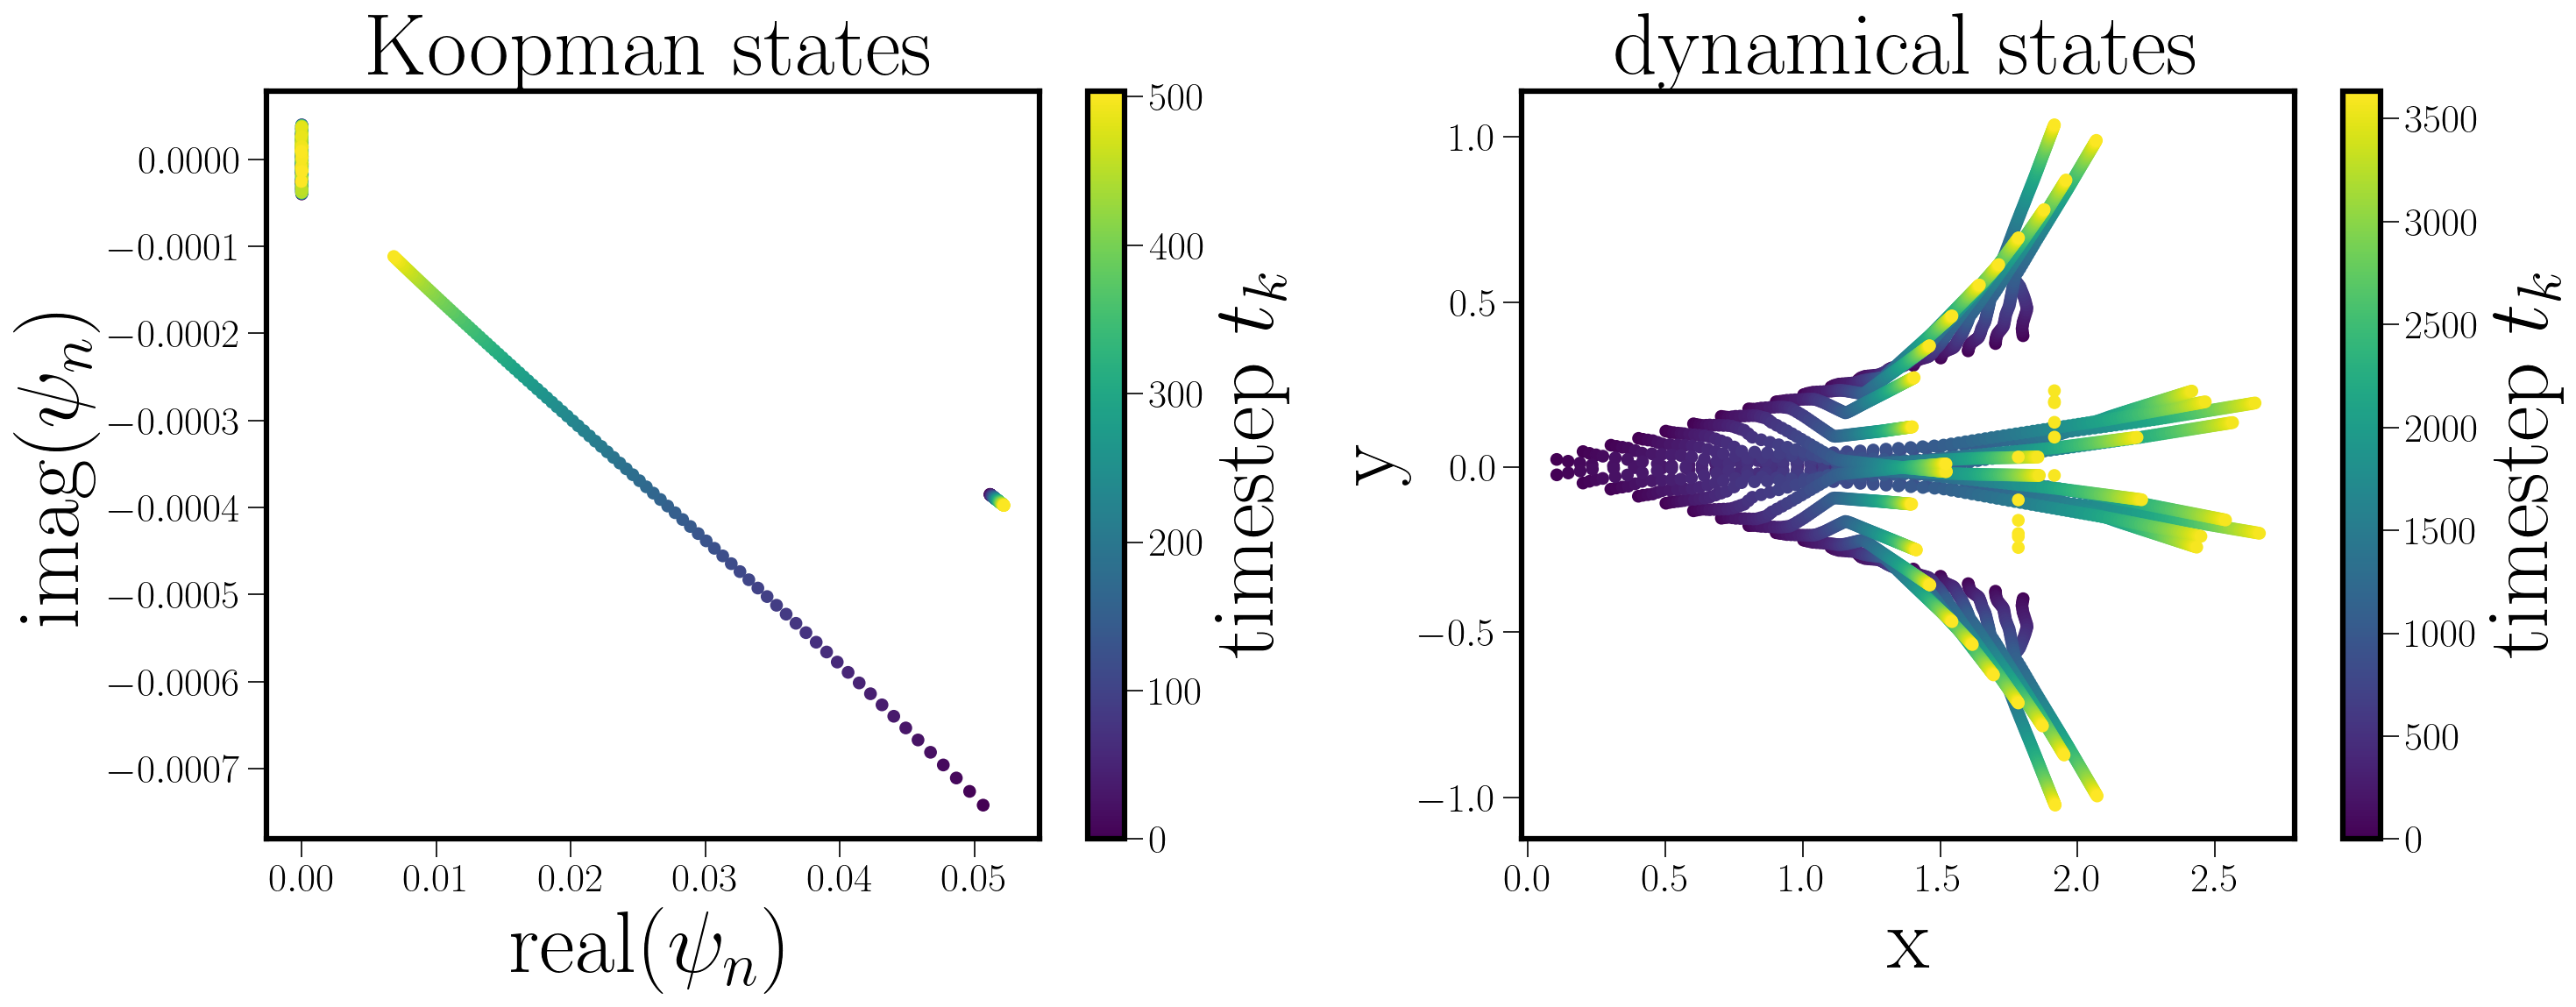

In [791]:
import matplotlib
from matplotlib import rc
from matplotlib import rcParams

def companion_plots(ks, dyn_sts, animate='off', frames=dict(), scale='off', flip='right', dual='on'):
    dcoords = int(dyn_sts.shape[1]/2)
    dyn_x = dyn_sts[:,0:dcoords]
    dyn_y = dyn_sts[:,dcoords:2*dcoords]

    dd = 1*(dual=='on')
    w = 2 - dd
    if dd:
        kcoords = int(ks.shape[1]/2)
        rks_x = ks[:,0:kcoords]
        rks_y = ks[:,kcoords:2*kcoords]

    if animate=='on':
        fsz = (16/w,8)
        frm = frames['frm']
        numFrames = frames['numFrames']
        endIdx = frames['endIdx']
        tSpan = frames['tSpan']
                    
        if frm<numFrames:
            nidx = endIdx
        else:
            nidx = endIdx-1
    else:
        fsz = (20/w,8)

    if isinstance(ks, list):
        rows = len(ks)
        fig, ax = plt.subplots(rows, 1+dd, figsize=fsz, dpi=150)
    else:
        rows = 1
        fig, ax = plt.subplots(rows, 1+dd, figsize=fsz, dpi=150)
        if dd:
            ax = ax[:,np.newaxis]
        else:
            ax = [ax]

    fs = 48
    for row in np.arange(rows):
        if flip=='right':
            if dd:
                kplt = ax[0,row]
                dynplt = ax[1,row]
            else:
                dynplt = ax[row]
        else:
            if dd:
                dynplt = ax[0,row]
                kplt = ax[1,row]
            else:
                dynplt = ax[row]

        if animate=='off':
            sm = dynplt.scatter(dyn_x, dyn_y, c=range(dyn_x.shape[0]*dyn_x.shape[1]), cmap='viridis')
            cbar = fig.colorbar(sm, ax=dynplt)
            cbar.set_label('timestep $t_k$', fontsize=fs)
            if dd:
                sm = kplt.scatter(rks_x, rks_y, c=range(rks_x.shape[0]*kcoords), cmap='viridis')
                cbar = fig.colorbar(sm, ax=kplt)
                cbar.set_label('timestep $t_k$', fontsize=fs)

        elif animate=='on':
            if dd:
                sm = kplt.plot(rks_x[:endIdx], rks_y[:endIdx], color='gray', linestyle='dashed')
                kplt.plot(rks_x[nidx], rks_y[nidx], color='navy', marker='o', linestyle='None')

            for alpha in np.arange(dcoords):
                ## COLOR SCHEME
                if prms['Gamma'][alpha]>0:
                    clr = 'blue'
                else:
                    clr = 'red'

                dynplt.plot(dyn_x[:endIdx,alpha], dyn_y[:endIdx,alpha], color='gray', linestyle='dashed')
                dynplt.plot(dyn_x[nidx,alpha], dyn_y[nidx,alpha], color=clr, marker='o', linestyle='None')

        if dd:
            kplt.set_title('Koopman states', fontsize=fs)
            kplt.set_xlabel('real($\psi_n$)', fontsize=fs)
            kplt.set_ylabel('imag($\psi_n$)', fontsize=fs)

        dynplt.set_title('dynamical states', fontsize=fs)
        dynplt.set_xlabel('x', fontsize=fs)
        dynplt.set_ylabel('y', fontsize=fs)

        if scale=='on':
            if dd:
                #kplt.set_xlim(-0.75, 0.2)
                #kplt.set_ylim(-0.5, 0.35)
                kplt.set_xlim(-0.04, 0.06)
                kplt.set_ylim(-0.0014, 0.0005)
            
            #dynplt.set_xlim(-2,4)
            #dynplt.set_ylim(-2,2)
            dynplt.set_xlim(-0.5,3)
            dynplt.set_ylim(-2,2)

    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':18})
    plt.tight_layout()

r = [rks, rks1, rks2]
kts = [dec_K_TS, dec_K_TS1, dec_K_TS2]
print(ks[-1,:])
companion_plots(rks, dec_K_TS)

In [866]:
u_res = 1000
new_ks_ends = np.ndarray((u_res), dtype='object')
new_ks = np.ndarray((u_res), dtype='object')
new_dyn = np.ndarray((u_res), dtype='object')

for j in np.arange(u_res):
    s = j/u_res
    new_ks_ends[j] = (1-s) * og_ends + s * koop_target_ends[0]
    new_ks[j] = time_series(ics, new_ks_ends[j], len(t))
    new_dyn[j] = n.decode_Koopman_TS(new_ks[j], NNlist[0])
    new_ks[j] = reweave(new_ks[j])

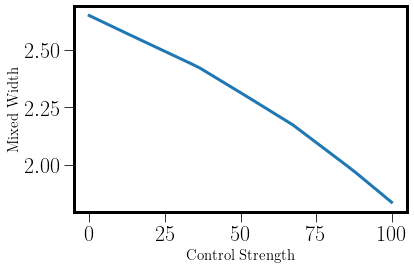

In [910]:
x_max = np.zeros(shape=(u_res))
for tr in np.arange(u_res):
    x_max[tr] = max(new_dyn[tr][-1,0:36])

fig, ax = plt.subplots(1)
ax.plot((np.arange(u_res)/u_res)*100, x_max)
ax.set_xlabel('Control Strength')
ax.set_ylabel('Mixed Width')

fig.tight_layout()
fig.savefig("images/ctrl_strength.png")

In [686]:
# Extract Fourier spectrum

# Number of sample points
N = 100#6000

# sample spacing
T = 1.0 / 100.0

#tf, yf1, ywf1, yf2, ywf2, xf1, xwf1, xf2, xwf2 = ExtractFFT(N, T, y_val, y_pred, x_val, x_pred)
#PlotFFT(tf, N, yf1, ywf1, yf2, ywf2, xf1, xwf1, xf2, xwf2)

[41.42986225 25.6657823  15.25926482 40.89703547 36.48589429 51.45300013
 25.86856979 12.08746742 39.94646587 47.45460759 30.35399381 12.49803898
 14.72733447 49.24302043 13.36259247 23.20421674 32.43054859 47.48203032
 40.35548488 52.51875941 28.10766866 34.29301582 13.30577488 18.13064591
 35.89963982 27.90496556 22.68685248 51.58080833 48.6869396  46.14248763
 19.51050049 36.9549884  40.11066484 18.72478312 31.29068506 51.09287143
 42.51876164 18.00409162 36.20689    19.06498601 39.84638743 17.41414819
 40.25077873 27.43428081 37.49400396 18.31112046 30.47300847 40.11651448
 33.31241858 47.53679001 24.73232228 46.2144147  19.81205782 50.28610039
 52.08493949 42.23494494 21.47598694 47.29406999 36.85906657 39.92294429
 32.55151436 38.16781722 51.46464873 46.04629167 41.72648463 43.97773086
 51.90673055 41.73205512 17.36860795 42.69754954 46.38151461 40.05797279
 21.0416537  36.10256345 42.31707858 35.17781151 52.16787048 30.56207901
 16.65527279 52.60377113 35.73523008 51.8876885  29

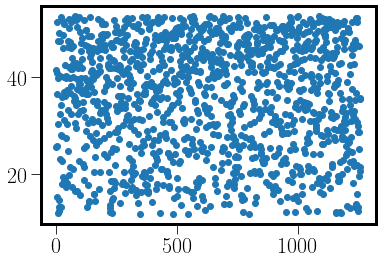

In [774]:
# Extract the slopes
import math

val = X_stacked
slps = (val[0,:,53] - val[0,:,36])/(val[0,:,17] - val[0,:,0])
slps = np.arctan(slps) * (180/np.pi)
xbase = range(len(slps))

print(slps[0:100])
plt.scatter(xbase, slps)

In [688]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LinearSegmentedColormap
import pdb
import csv
from scipy.integrate import odeint
from random import sample

# provided dataset structure: [N,M]x[T,K,P]
# N neural nets and M datasets (must be TVTs: Training-Validation-Test type)
# T time-steps, K is the number of trajectories, and P the number of coordinates/components of motion.

def grab_fig(NTs, NNs, option):
    if option=='grid':
        xs = max(6*NTs, 15)
        ys = max(6*NNs - 1, 15)
        fig, ax = plt.subplots(NNs, NTs, figsize=(xs, ys), dpi=150)
    elif option=='overlay':
        fig, ax = plt.subplots(1, figsize=(15, 15), dpi=150)
        
    return fig, ax


def grab_axl(ax,col):
    if type(ax)==np.ndarray:
        if len(ax.shape)>1:
            axl = ax[col,:].flat
        else:
            axl = [ax[col]]
    elif type(ax)==list:
        axl = ax
    else:
        axl = [ax]
    
    return axl


def animate_trajs(trajlist, dataset, prms, option='grid', scale='on', flip='right', dual='on'):
    # Generate movie frames
    T = dataset[0].shape[0]-1
    numFrames = round(T/5)
    for tdx in range(numFrames+1):
        endIdx = int((tdx)/float(numFrames) * T)

        frames = {'frm': tdx, 'endIdx': endIdx, 'numFrames': numFrames, 'tSpan': tSpan}
        #fig, ax = single_frame_trajs(trajlist, dataset, frames, prms, option=option, scale=scale)
        companion_plots(dataset[0], dataset[1], animate='on', frames=frames, scale=scale, flip=flip, dual=dual)

        plt.tight_layout()
        print('Saving frame %s' % tdx)
        plt.savefig("images/jetsframe{:04}.png".format(tdx))
        plt.close()
    
    return numFrames

def single_frame_trajs(trajlist, dataset, frames, prms, option='grid', scale='off'):
    # Cycle through the trajectories in the dataset provided and plot one frame for all of it.
    NTs = len(trajlist)
    NNs = len(dataset)
    N = int(np.floor(dataset[0].shape[2]/2)) # Number of vortices
    
    frm = frames['frm']
    numFrames = frames['numFrames']
    endIdx = frames['endIdx']
    tSpan = frames['tSpan']

    # Initialise the subplot function using number of rows and columns
    fig, ax = grab_fig(NTs, NNs, option)
        
    for tr, traj in enumerate(trajlist):
        axl = grab_axl(ax,tr)
        for idx, axs in enumerate(axl):
            data = dataset[idx]
            x_data = data[:,traj,0:N]
            y_data = data[:,traj,N:2*N]
            for alpha in range(N):
                ## COLOR SCHEME
                if option=='grid':
                    if prms['Gamma'][alpha]>0:
                        clr = 'blue'
                    else:
                        clr = 'red'
                elif option=='overlay':
                    clrs = ['gray', 'navy', 'purple']
                    clr = clrs[tr]

                if frm<numFrames:
                    nidx = endIdx
                else:
                    nidx = endIdx-1

                # if overlay style, do not show history
                if option=='grid':
                    axs.plot(x_data[:endIdx,alpha], y_data[:endIdx,alpha], color='gray', linestyle='dashed')

                axs.plot(x_data[nidx,alpha], y_data[nidx,alpha], color=clr, marker='o', linestyle='None')

            ratio = 1
            axs.set(xlabel='X ($mm$)', ylabel='Y ($mm$)')
            if scale=='on':
                axs.set_xlim(-2,4)
                axs.set_ylim(-2,2)
            axs.label_outer()
            axs.yaxis.tick_left()
            axs.xaxis.tick_bottom()
            xleft, xright = axs.get_xlim()
            ybottom, ytop = axs.get_ylim()
            axs.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

        if frm<numFrames:
            fig.suptitle('Time = {:.2f} $\\mu $s'.format(tSpan[endIdx]))
        else:
            fig.suptitle('Time = {:.2f} $\\mu $s'.format(tSpan[endIdx-1]))

        matplotlib.rc('xtick', labelsize=22) 
        matplotlib.rc('ytick', labelsize=22)
    
    return fig, ax

def plt_rainbow_trajs(trajlist, dataset, option='dyn_states', option2='grid'):
    # Must be a single dataset, but may be multiple neural networks
    # Cycle through the trajectories and the dataset provided and build rainbow plots for all of it.
    data = dataset[0]
    C = data.shape[2]
    NTs = len(trajlist)
    NNs = len(dataset)
    N = int(np.floor(C/2)) # number of vortices

    # Initialise the subplot function using number of rows and columns
    fig, ax = grab_fig(NTs, NNs, option2)

    for tr, traj in enumerate(trajlist):
        axl = grab_axl(ax,tr)
        for idx, axs in enumerate(axl):
            if option=='dyn_states':
                for k in range(N):
                    axs.scatter(data[:,traj,k],data[:,traj,N+k])
            elif option=='koop_states':
                for k in range(C):
                    axs.plot(data[:,traj,k])

In [924]:
new_ks.shape

(1000,)

In [922]:
dataset = [new_ks[500], new_dyn[500]]
grndtruth = [X_stacked[:,0,:], X_stacked[:,0,:]]
#trajlist = [3, 30, 100, 110, 300]
trajlist = [0,1,2]
NTs = len(trajlist)
NNs = len(dataset)

#dataset = build_dataset(trajlist, sources)
numFrames = animate_trajs(trajlist, dataset, params, option='overlay', flip='left', dual='off')
#numFrames = animate_trajs([0], grndtruth, params, option='grid')

Saving frame 0
Saving frame 1
Saving frame 2
Saving frame 3
Saving frame 4
Saving frame 5
Saving frame 6
Saving frame 7
Saving frame 8
Saving frame 9
Saving frame 10
Saving frame 11
Saving frame 12
Saving frame 13
Saving frame 14
Saving frame 15
Saving frame 16
Saving frame 17
Saving frame 18
Saving frame 19
Saving frame 20


Saving movie
Done


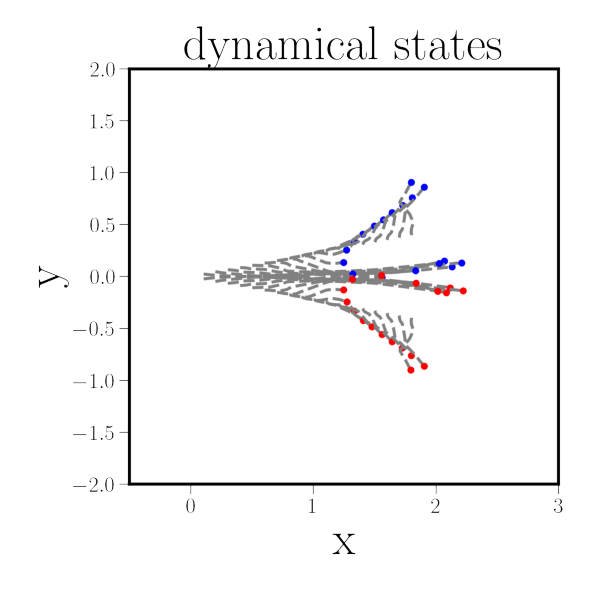

In [923]:
def animate(i):
    plt.clf()
    im = plt.imread("images/jetsframe{:04}.png".format(i))
    plt.axis('off')
    plt.imshow(im)

fig, ax = plt.subplots(1,figsize=(12, 8))
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)

print('Saving movie')
anim = FuncAnimation(plt.gcf(), animate, frames=numFrames, interval=(2000.0/numFrames))
anim.save('images/gifs/jets.gif', writer='pillow')
print('Done')

In [916]:
trajlist = [3, 30, 100, 110, 300]
#dataset = [dyn_states[0,0]]
dataset = [omegas]

plt_rainbow_trajs(trajlist,dataset,'koop_states','grid')

IndexError: tuple index out of range

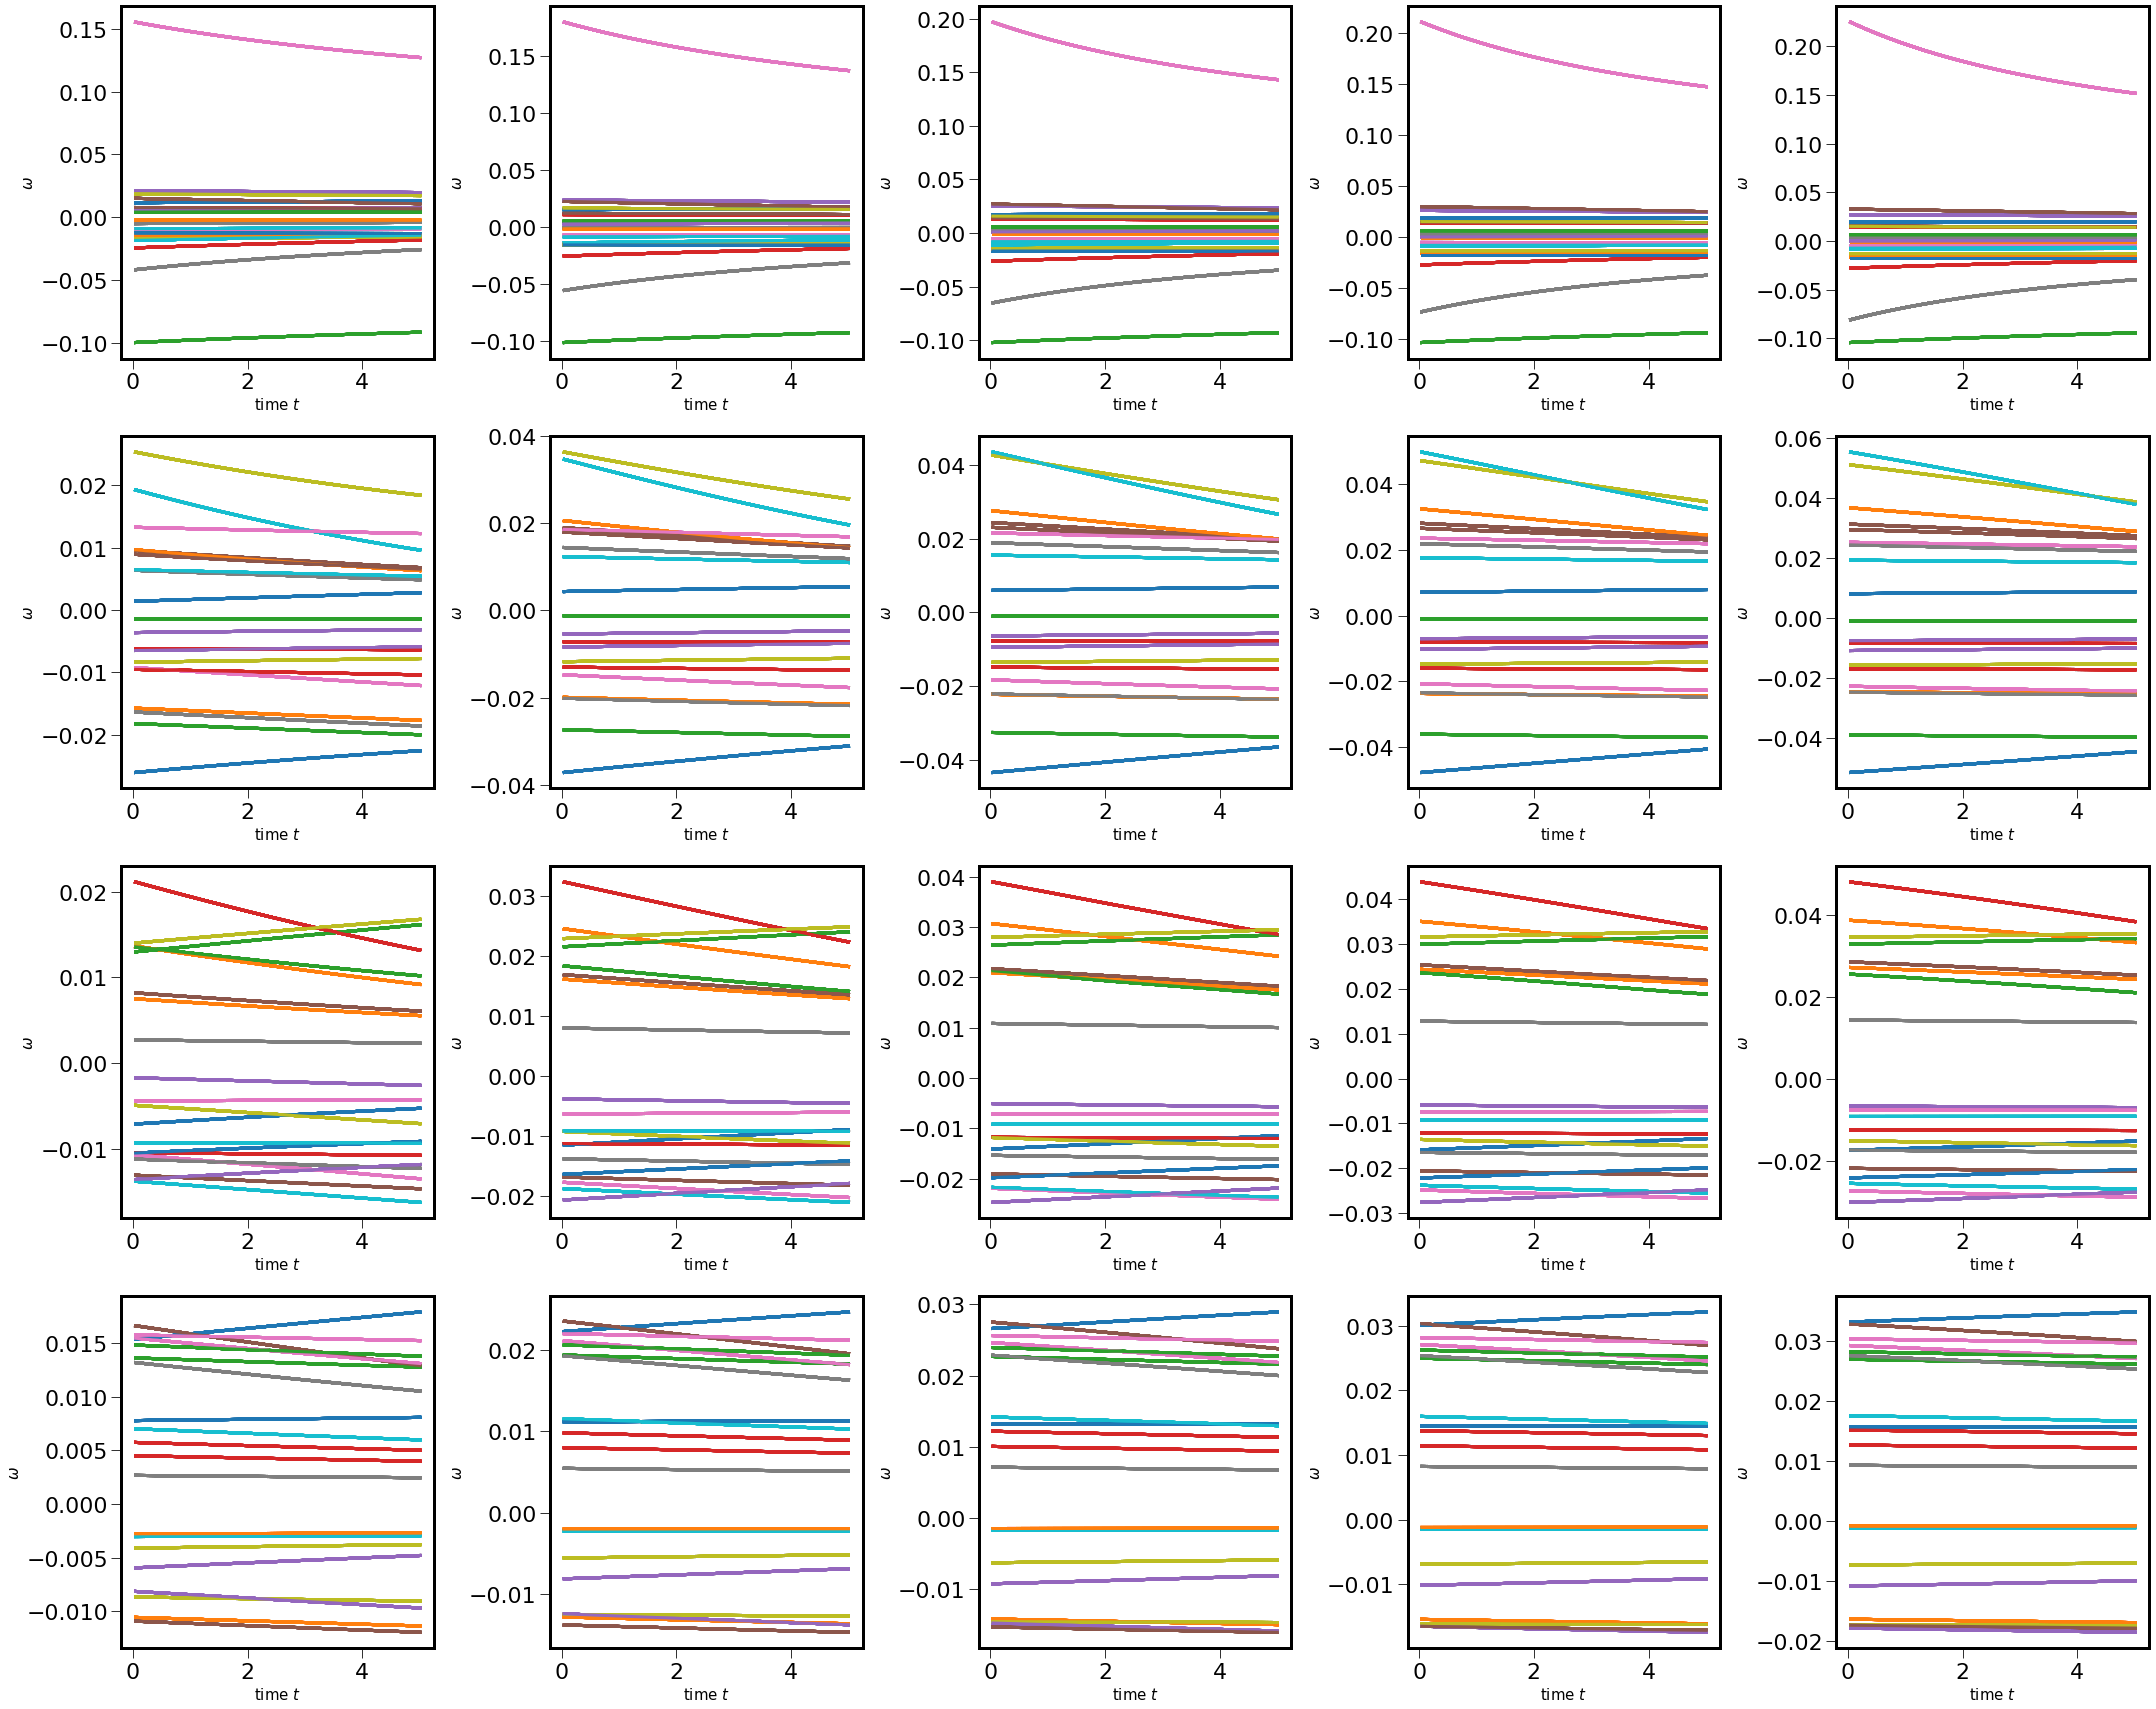

In [58]:
# Initialise the subplot function using number of rows and columns
fig, ax = plt.subplots(NNs, NTs, figsize=(30,24))

for tr, traj in enumerate(trajlist):
    for k in range(N):
        for idx, nn in enumerate(NNlist):
            ax[idx,tr].plot(t[1:], omegass[tr][idx])
            ax[idx,tr].set_ylabel(r'$\omega$')
            ax[idx,tr].set_xlabel(r'time $t$')

plt.tight_layout()

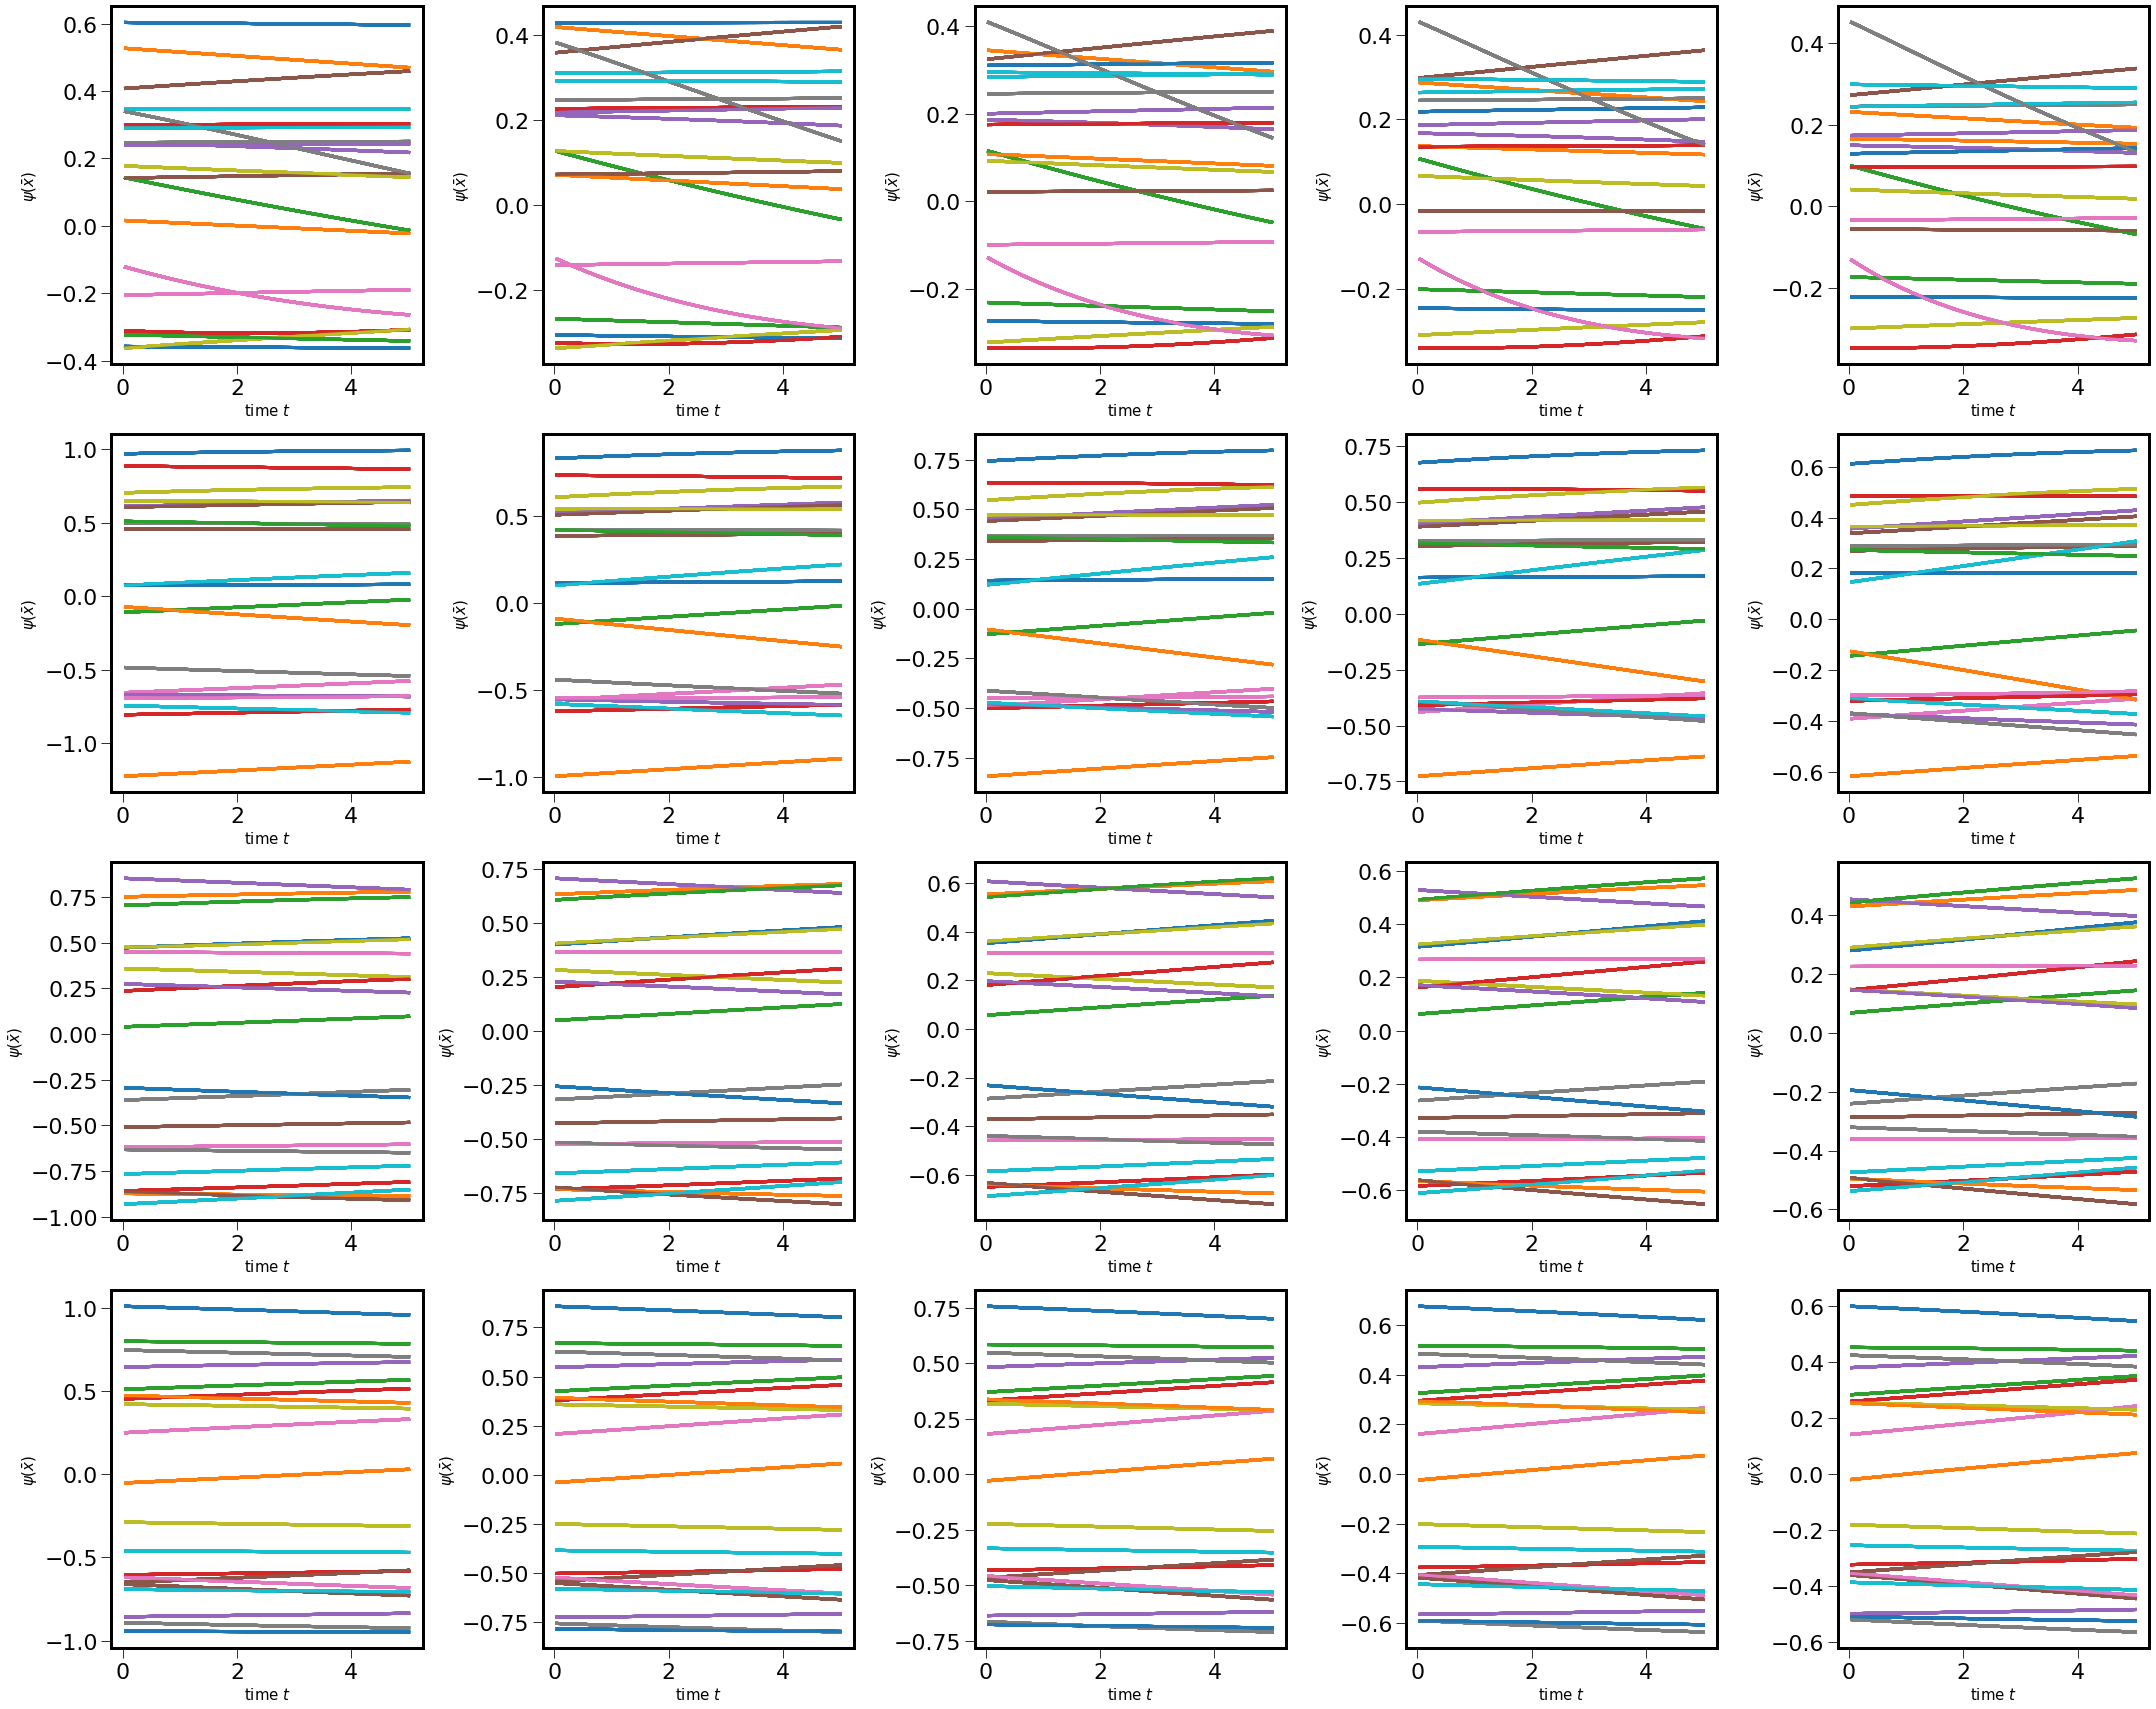

In [59]:
fig, ax = plt.subplots(NNs, NTs, figsize=(30,24))

for tr, traj in enumerate(trajlist):
    for k in range(N):
        for idx, nn in enumerate(NNlist):          
            ax[idx,tr].plot(t[1:], koop_statess[tr][idx])
            ax[idx,tr].set_ylabel(r'$\psi(\bar{x})$')
            ax[idx,tr].set_xlabel(r'time $t$')

plt.tight_layout()

In [55]:
np.where(np.floor(slps) == 35)

(array([  52,   87,  100,  143,  183,  196,  205,  256,  260,  323,  335,
         357,  419,  450,  456,  500,  520,  622,  689,  697,  798,  809,
         842, 1037, 1078, 1159, 1166], dtype=int64),)

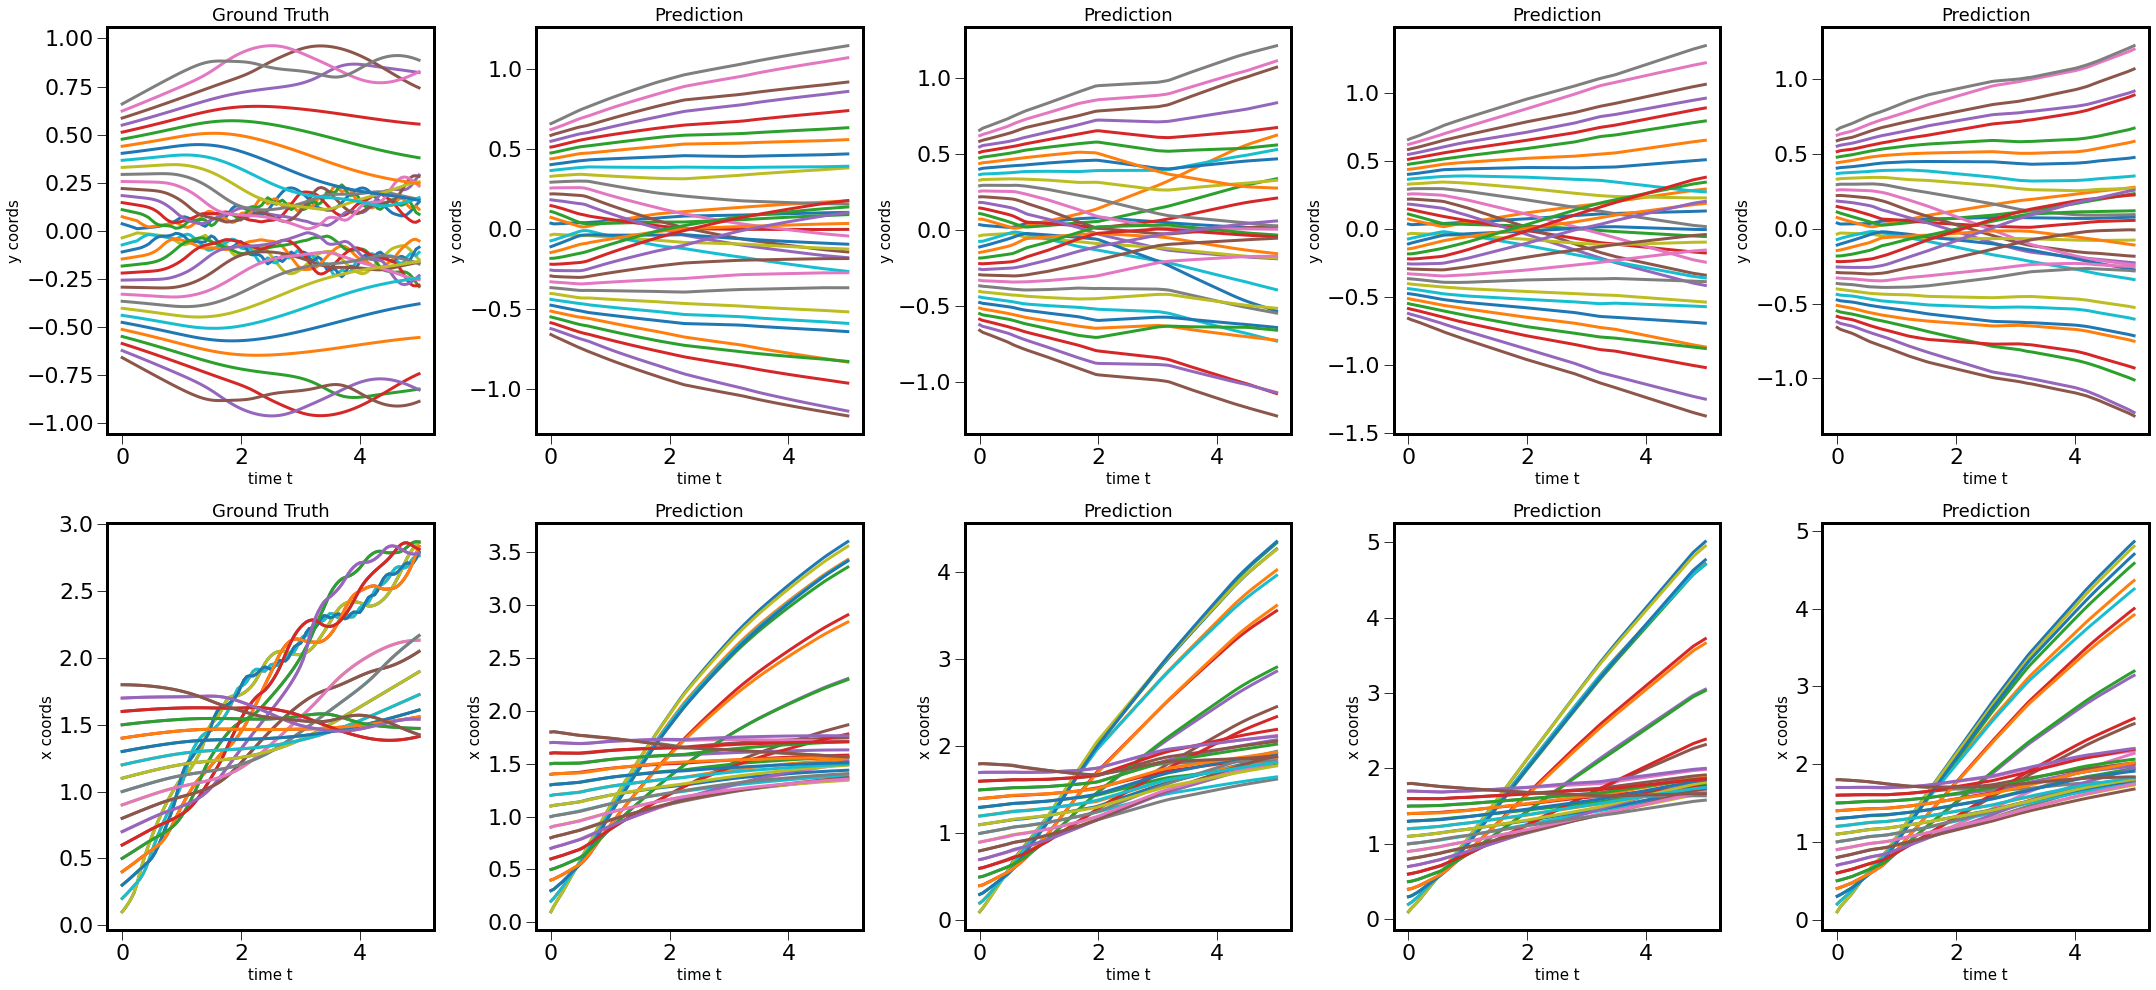

In [57]:
# New figure
fig, ax = plt.subplots(2,NNs+1,figsize=(30,14))

for idx, nn in enumerate(NNlist):
    ax[0,idx+1].plot(t, y_pred[idx])
    ax[1,idx+1].plot(t, x_pred[idx])
    ax[0,idx+1].set_title('Prediction')
    ax[1,idx+1].set_title('Prediction')
    ax[0,idx+1].set_ylabel('y coords')
    ax[1,idx+1].set_ylabel('x coords')

ax[0,0].plot(t, y_val)
ax[1,0].plot(t, x_val)

for axs in ax.flatten():
    axs.set_xlabel('time t')

ax[0,0].set_title('Ground Truth')
ax[1,0].set_title('Ground Truth')
ax[0,0].set_ylabel('y coords')
ax[1,0].set_ylabel('x coords')

plt.tight_layout()

In [30]:
import numpy.random as rnd
#slopes, Gamma = params['varyingparams']
Gamma = np.array([ 0.1       ,  0.09428731,  0.08890098,  0.08382234,  0.07903384,  0.07451888,  0.07026185,  0.06624801,  0.06246347,  0.05889513,
        0.05553064,  0.05235835,  0.04936728,  0.04654708,  0.04388799,  0.04138081,  0.03901685,  0.03678794, -0.1, -0.09428731, -0.08890098, -0.08382234, -0.07903384, -0.07451888, -0.07026185,
       -0.06624801, -0.06246347, -0.05889513, -0.05553064, -0.05235835, -0.04936728, -0.04654708, -0.04388799, -0.04138081, -0.03901685,  -0.03678794])

prms = params[0]
prms['misc'] = [0.1, 1.8, 18, 36,np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
deltax, linerlength, numvort, N, incT = prms['misc']

#vtraj = rnd.randint(1500,size=N)
#vtraj[0] = 783

N = 36
pred = rings_long_pred[2]
val = X_stacked

x_idx = np.array(range(N))
y_idx = x_idx + N

T = len(tSpan)
NTr = rings.shape[1]

sh1 = (T,NTr,N)
sh2 = (T,NTr)

In [31]:
# Measures of accuracy and conserved quantities, etc.
H = np.zeros(sh2)

avg_spc_L2_err = np.zeros(sh2)
avg_time_spc_L2_err = np.zeros(NTr)

pred_x_imp = np.zeros(sh1)
pred_y_imp = np.zeros(sh1)
pred_ang_imp = np.zeros(sh1)
val_x_imp = np.zeros(sh1)
val_y_imp = np.zeros(sh1)
val_ang_imp = np.zeros(sh1)

x_imp_err = np.zeros((sh1) + (2,))
y_imp_err = np.zeros((sh1) + (2,))
ang_imp_err = np.zeros((sh1) + (2,))

pred_avg_spc_x_imp = np.zeros(sh2)
pred_avg_spc_y_imp = np.zeros(sh2)
pred_avg_spc_ang_imp = np.zeros(sh2)
val_avg_spc_x_imp = np.zeros(sh2)
val_avg_spc_y_imp = np.zeros(sh2)
val_avg_spc_ang_imp = np.zeros(sh2)
avg_spc_x_imp_err = np.zeros(sh2)
avg_spc_y_imp_err = np.zeros(sh2)
avg_spc_ang_imp_err = np.zeros(sh2)

pred_avg_time_spc_x_imp = np.zeros(NTr)
pred_avg_time_spc_y_imp = np.zeros(NTr)
pred_avg_time_spc_ang_imp = np.zeros(NTr)
val_avg_time_spc_x_imp = np.zeros(NTr)
val_avg_time_spc_y_imp = np.zeros(NTr)
val_avg_time_spc_ang_imp = np.zeros(NTr)
avg_time_spc_x_imp_err = np.zeros(NTr)
avg_time_spc_y_imp_err = np.zeros(NTr)
avg_time_spc_ang_imp_err = np.zeros(NTr)

for k in range(N):
    pred_x_imp[:,:,k] = Gamma[k] * pred[:,:,k]
    val_x_imp[:,:,k] = Gamma[k] * val[:,:,k]
    pred_y_imp[:,:,k] = Gamma[k] * pred[:,:,k]
    val_y_imp[:,:,k] = Gamma[k] * val[:,:,k]
    pred_ang_imp[:,:,k] = Gamma[k] * (pred[:,:,k]**2 + pred[:,:,k]**2)
    val_ang_imp[:,:,k] = Gamma[k] * (val[:,:,k]**2 + val[:,:,k]**2)

L2_err = (pred - val)**2

x_imp_err[:,:,:,0] = abs(pred_x_imp - val_x_imp)
y_imp_err[:,:,:,0] = abs(pred_y_imp - val_y_imp)
ang_imp_err[:,:,:,0] = abs(pred_ang_imp - val_ang_imp)
    
x_imp_err[:,:,:,1] = x_imp_err[:,:,:,0]**2 # L2 error is L1 error squared eleent-wise
y_imp_err[:,:,:,1] = y_imp_err[:,:,:,0]**2
ang_imp_err[:,:,:,1] = ang_imp_err[:,:,:,0]**2

# Range over the trajectories
for tr in range(NTr):
    
    # Range over the time-steps
    for t in range(T):

        avg_spc_L2_err[t,tr] = np.mean(L2_err[t,tr,:])
        avg_spc_x_imp_err[t,tr] = np.mean(x_imp_err[t,tr,:])
        avg_spc_y_imp_err[t,tr] = np.mean(y_imp_err[t,tr,:])
        avg_spc_ang_imp_err[t,tr] = np.mean(ang_imp_err[t,tr,:])
        
        pred_avg_spc_x_imp[t,tr] = np.mean(pred_x_imp[t,tr,:])
        pred_avg_spc_y_imp[t,tr] = np.mean(pred_y_imp[t,tr,:])
        pred_avg_spc_ang_imp[t,tr] = np.mean(pred_ang_imp[t,tr,:])
        
        val_avg_spc_x_imp[t,tr] = np.mean(val_x_imp[t,tr,:])
        val_avg_spc_y_imp[t,tr] = np.mean(val_y_imp[t,tr,:])
        val_avg_spc_ang_imp[t,tr] = np.mean(val_ang_imp[t,tr,:])
    
    avg_time_spc_L2_err[tr] = np.mean(avg_spc_L2_err[:,tr])
    avg_time_spc_x_imp_err[tr] = np.mean(avg_spc_x_imp_err[:,tr])
    avg_time_spc_y_imp_err[tr] = np.mean(avg_spc_y_imp_err[:,tr])
    avg_time_spc_ang_imp_err[tr] = np.mean(avg_spc_ang_imp_err[:,tr])
    
    pred_avg_time_spc_x_imp[tr] = np.mean(pred_avg_spc_x_imp[:,tr])
    pred_avg_time_spc_y_imp[tr] = np.mean(pred_avg_spc_y_imp[:,tr])
    pred_avg_time_spc_ang_imp[tr] = np.mean(pred_avg_spc_ang_imp[:,tr])
    
    val_avg_time_spc_x_imp[tr] = np.mean(val_avg_spc_x_imp[:,tr])
    val_avg_time_spc_y_imp[tr] = np.mean(val_avg_spc_y_imp[:,tr])
    val_avg_time_spc_ang_imp[tr] = np.mean(val_avg_spc_ang_imp[:,tr])

664 319


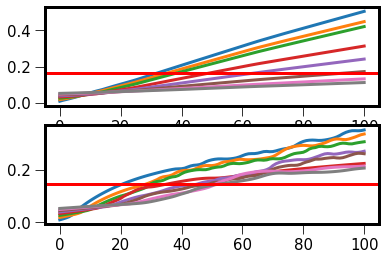

In [32]:
# Find the trajectory with the strongest jet! 8 vortices on either side shows plenty.

core = 8
trajs = NTr

pred_imps = [0]*trajs
pred_ang_imps = [0]*trajs

pred_avg_imp = [0]*trajs
pred_avg_ang_imp = [0]*trajs

pred_max_imp = [0]*trajs
pred_max_ang_imp = [0]*trajs

val_imps = [0]*trajs
val_ang_imps = [0]*trajs

val_avg_imp = [0]*trajs
val_avg_ang_imp = [0]*trajs

val_max_imp = [0]*trajs
val_max_ang_imp = [0]*trajs

for traj in range(trajs):
    pred_imps[traj] = pred_x_imp[:,traj,0:core]
    pred_ang_imps[traj] = pred_ang_imp[:,traj,0:core]
    
    val_imps[traj] = val_x_imp[:,traj,0:core]
    val_ang_imps[traj] = val_ang_imp[:,traj,0:core]

    pred_avg_imp[traj] = np.mean(pred_imps[traj])
    pred_max_imp[traj] = np.max(pred_imps[traj])

    pred_avg_ang_imp[traj] = np.mean(pred_ang_imps[traj])
    pred_max_ang_imp[traj] = np.max(pred_ang_imps[traj])

    val_avg_imp[traj] = np.mean(val_imps[traj])
    val_max_imp[traj] = np.max(val_imps[traj])
    
    val_avg_ang_imp[traj] = np.mean(val_ang_imps[traj])
    val_max_ang_imp[traj] = np.max(val_ang_imps[traj])

pred_loc = np.where(pred_imps == np.max(pred_imps))[0][0]
val_loc = np.where(val_imps == np.max(val_imps))[0][0]

print(pred_loc, val_loc)

fig, ax = plt.subplots(2,1)
ax[0].plot(pred_imps[pred_loc])
ax[0].axhline(y=pred_avg_imp[traj], color='r', linestyle='-')
ax[1].plot(val_imps[val_loc])
ax[1].axhline(y=val_avg_imp[traj], color='r', linestyle='-')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


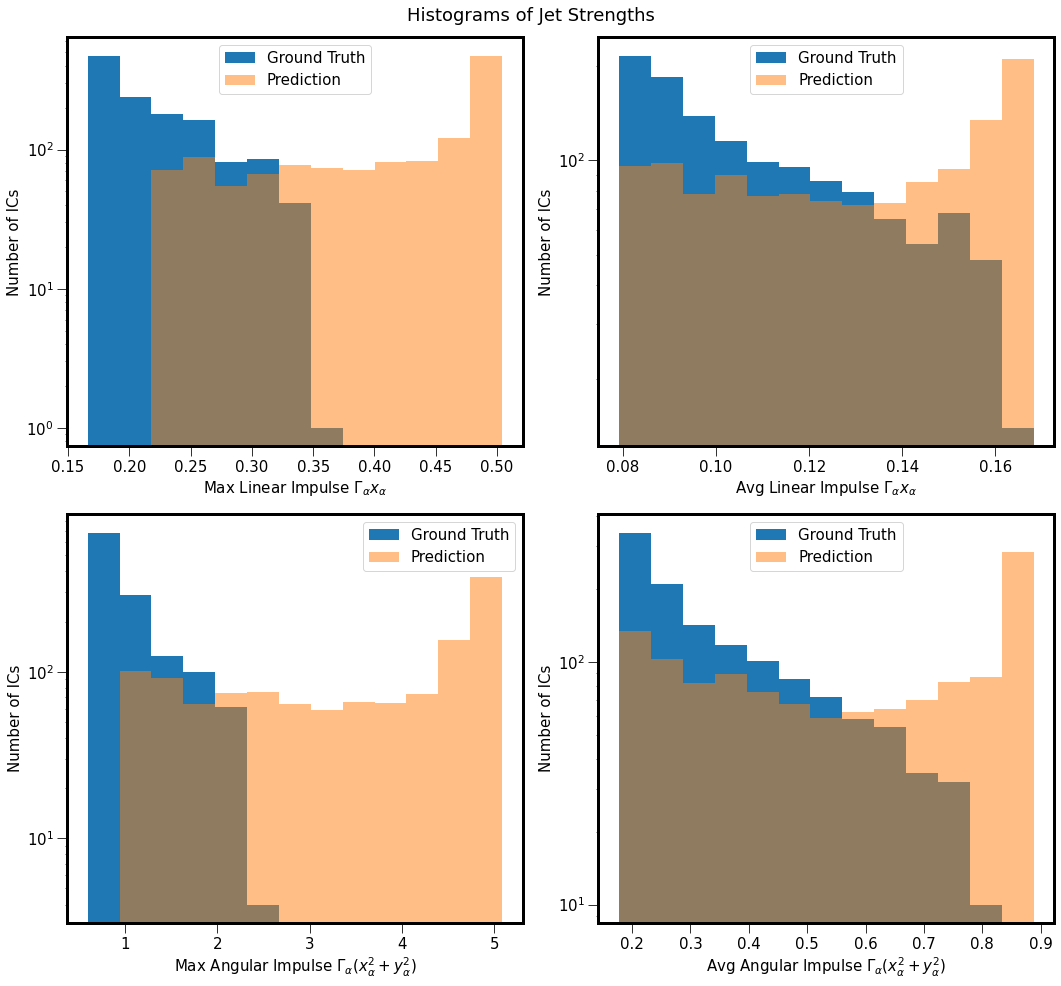

In [33]:
fig, ax = plt.subplots(2,2,figsize=(15,14))

a=val_max_imp
b=pred_max_imp
bins=np.histogram(np.hstack((a,b)), bins='auto')[1] #get the bin edges
ax[0,0].hist(val_max_imp, bins=bins)
ax[0,0].hist(pred_max_imp, bins=bins, alpha=0.5)

a=val_avg_imp
b=pred_avg_imp
bins=np.histogram(np.hstack((a,b)), bins='auto')[1] #get the bin edges
ax[0,1].hist(val_avg_imp, bins=bins)
ax[0,1].hist(pred_avg_imp, bins=bins, alpha=0.5)

a=val_max_ang_imp
b=pred_max_ang_imp
bins=np.histogram(np.hstack((a,b)), bins='auto')[1] #get the bin edges
ax[1,0].hist(val_max_ang_imp, bins=bins)
ax[1,0].hist(pred_max_ang_imp, bins=bins, alpha=0.5)

a=val_avg_ang_imp
b=pred_avg_ang_imp
bins=np.histogram(np.hstack((a,b)), bins='auto')[1] #get the bin edges
ax[1,1].hist(val_avg_ang_imp, bins=bins)
ax[1,1].hist(pred_avg_ang_imp, bins=bins, alpha=0.5)

for axs in ax.flatten():
    axs.set_yscale('log')
    axs.legend(["Ground Truth", "Prediction"])
    axs.set_ylabel('Number of ICs')

fig.suptitle('Histograms of Jet Strengths')
ax[0,0].set_xlabel(r'Max Linear Impulse $\Gamma_{\alpha} x_{\alpha}$')
ax[0,1].set_xlabel(r'Avg Linear Impulse $\Gamma_{\alpha} x_{\alpha}$')
ax[1,0].set_xlabel(r'Max Angular Impulse $\Gamma_{\alpha} (x_{\alpha}^2 + y_{\alpha}^2)$')
ax[1,1].set_xlabel(r'Avg Angular Impulse $\Gamma_{\alpha} (x_{\alpha}^2 + y_{\alpha}^2)$')

plt.tight_layout()

NameError: name 'slps' is not defined

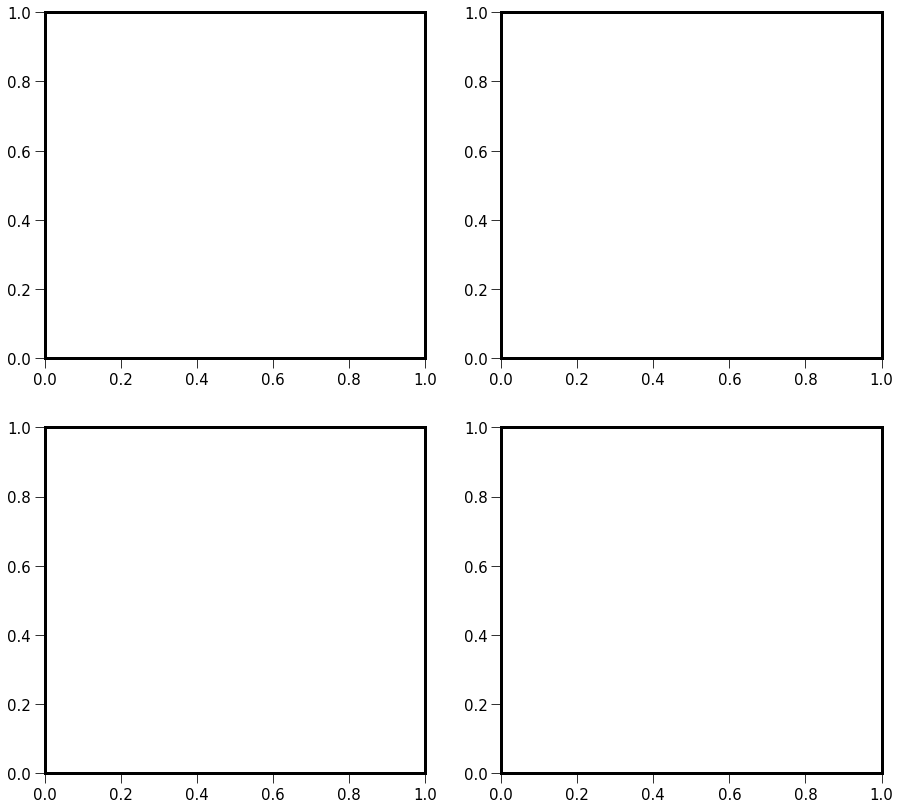

In [34]:
fig, ax = plt.subplots(2,2,figsize=(15,14))

ax[0,0].scatter(slps, val_max_imp)
ax[0,0].scatter(slps, pred_max_imp)

ax[0,1].scatter(slps, val_avg_imp)
ax[0,1].scatter(slps, pred_avg_imp)

ax[1,0].scatter(slps, val_max_ang_imp)
ax[1,0].scatter(slps, pred_max_ang_imp)

ax[1,1].scatter(slps, val_avg_ang_imp)
ax[1,1].scatter(slps, pred_avg_ang_imp)

for axs in ax.flatten():
    axs.legend(["Ground Truth", "Prediction"])
    axs.set_xlabel(r'Slope $\theta^\circ$')

fig.suptitle('Jet Strength v.s. Slope')
ax[0,0].set_ylabel(r'Max Linear Impulse $\Gamma_{\alpha} x_{\alpha}$')
ax[0,1].set_ylabel(r'Avg Linear Impulse $\Gamma_{\alpha} x_{\alpha}$')
ax[1,0].set_ylabel(r'Max Angular Impulse $\Gamma_{\alpha} (x_{\alpha}^2 + y_{\alpha}^2)$')
ax[1,1].set_ylabel(r'Avg Angular Impulse $\Gamma_{\alpha} (x_{\alpha}^2 + y_{\alpha}^2)$')

plt.tight_layout()

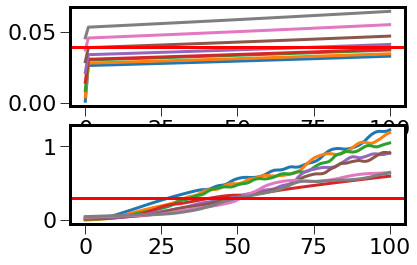

In [362]:
fig, ax = plt.subplots(2,1)
ax[0].plot(pred_ang_imps[pred_loc])
ax[0].axhline(y=pred_avg_ang_imp[traj], color='r', linestyle='-')
ax[1].plot(val_ang_imps[val_loc])
ax[1].axhline(y=val_avg_ang_imp[traj], color='r', linestyle='-')

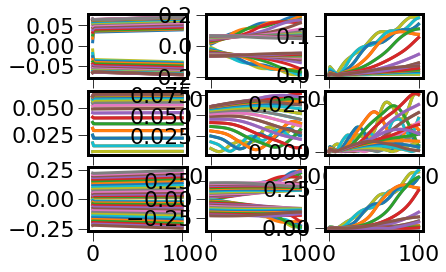

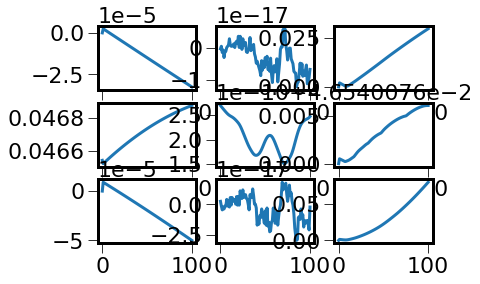

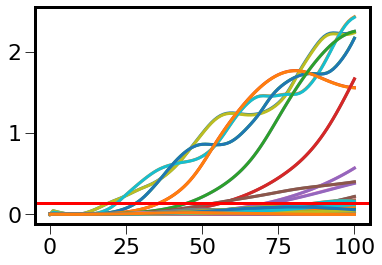

In [366]:
figure, axis = plt.subplots(3,3)

axis[0,0].plot(pred_x_imp[:,tr,:])
axis[1,0].plot(pred_y_imp[:,tr,:])
axis[2,0].plot(pred_ang_imp[:,tr,:])

axis[0,1].plot(val_x_imp[:,tr,:])
axis[1,1].plot(val_y_imp[:,tr,:])
axis[2,1].plot(val_ang_imp[:,tr,:])

axis[0,2].plot(x_imp_err[:,tr,:,0])
axis[1,2].plot(y_imp_err[:,tr,:,0])
axis[2,2].plot(ang_imp_err[:,tr,:,0])

figure, axis = plt.subplots(3,3)

axis[0,0].plot(pred_avg_spc_x_imp[:,tr])
axis[1,0].plot(pred_avg_spc_y_imp[:,tr])
axis[2,0].plot(pred_avg_spc_ang_imp[:,tr])

axis[0,1].plot(val_avg_spc_x_imp[:,tr])
axis[1,1].plot(val_avg_spc_y_imp[:,tr])
axis[2,1].plot(val_avg_spc_ang_imp[:,tr])

axis[0,2].plot(avg_spc_x_imp_err[:,tr])
axis[1,2].plot(avg_spc_y_imp_err[:,tr])
axis[2,2].plot(avg_spc_ang_imp_err[:,tr])
    
fig = plt.figure(4)
plt.plot(L2_err[:,tr,:])
plt.axhline(y=avg_time_spc_L2_err[tr], color='r', linestyle='-')
plt.show()

In [244]:
# shape: num_examples, num_steps, n
# send initial conditions through network again, but predict many steps (50)
print('We now predict the initial conditions %d steps forward' % max_shifts_to_stack)
long_pred_Xk = n.PredictKoopmanNetOmegas(Xk, W, b, deltat, max_shifts_to_stack, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])


We now predict the initial conditions 100 steps forward


AttributeError: 'int' object has no attribute 'PredictKoopmanNetOmegas'

In [ ]:
# how does prediction error change with the number of prediction steps?
# we expect it to accumulate error, but hopefully not too fast
long_pred_error = np.zeros((max_shifts_to_stack, ))
for j in np.arange(max_shifts_to_stack):
    long_pred_error[j] = np.mean(np.mean(np.square(long_pred_Xk[:,j,:] - X_stacked[j+1,:,:]), axis=0)) 

In [ ]:
# so we can put ticks in good places
print('log10 error ranges from %.2f to %.2f' % (min(np.log10(long_pred_error)), max(np.log10(long_pred_error))))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16)
fig.set_figheight(16/3*2)

plt.plot(np.arange(max_shifts_to_stack), np.log10(long_pred_error), linewidth=3)

xlab = [0,max_shifts_to_stack/2,max_shifts_to_stack]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-4.0,-4.4,-4.8]
ylabels = ''
plt.yticks(ylab,ylabels)
fig.savefig('PendulumPredOverSteps.svg', dpi=200, transparent=True)

In [ ]:
# moved this to the bottom because it's so slow
loss1_train, loss2_train, loss3_train, loss_Linf_train, loss_train, regularized_loss_train, total_num_traj = n.loss_training(params, max_shifts_to_stack, W, b)
print("# training traj: %d (goes in Table 2)" % total_num_traj)
print("Note: accidentally reported in paper that we used more data than we did.")
print("See Pendulum.m: used 5000*.7 = 3500 per file, not 5000")

In [ ]:
print('Reconstruction loss (on train set): %.4E' % loss1_train)
print('Prediction loss (on train set): %.4E' % loss2_train)
print('Linearity loss (on train set): %.4E' % loss3_train)
print('L_inf loss (on train set): %.4E' % loss_Linf_train)
print('Pre-regularization loss (on train set): %.4E (goes in Table 1)' % loss_train)
print('Total regularized loss (on train set): %.4E' % regularized_loss_train)

# Test error

DO NOT CALCULATE UNTIL READY TO REPORT FINAL RESULTS

In [ ]:
## We decided to report this example in the paper, so now we can calcuate test errror
#loss1_test, loss2_test, loss3_test, loss_Linf_test, loss_test, regularized_loss_test = n.loss_test(params, max_shifts_to_stack, W, b)
#print("Note: accidentally reported in paper that we used more data than we did.")
#print("See Pendulum.m: used 5000*.1 = 500 for testing, not 5000")

In [ ]:
#print('Reconstruction loss (on test set): %.4E' % loss1_test)
#print('Prediction loss (on test set): %.4E' % loss2_test)
#print('Linearity loss (on test set): %.4E' % loss3_test)
#print('L_inf loss (on test set): %.4E' % loss_Linf_test)
#print('Pre-regularization loss (on test set): %.4E (goes in Table 1)' % loss_test)
#print('Total regularized loss (on test set): %.4E' % regularized_loss_test)

In [ ]:
#print("Could be that error would be higher on larger test set, so try larger one.")
#print("Check test error on larger test set:")
#loss1_testextra, loss2_testextra, loss3_testextra, loss_Linf_testextra, loss_testextra, regularized_loss_testextra = n.loss_test(params, max_shifts_to_stack, W, b, suffix='testextra')
#print('Reconstruction loss (on larger test set): %.4E' % loss1_testextra)
#print('Prediction loss (on larger test set): %.4E' % loss2_testextra)
#print('Linearity loss (on larger test set): %.4E' % loss3_testextra)
#print('L_inf loss (on larger test set): %.4E' % loss_Linf_testextra)
#print('Pre-regularization loss (on larger test set): %.4E (compare to numbers in Table 1)' % loss_testextra)
#print('Total regularized loss (on larger test set): %.4E' % regularized_loss_testextra)

In [ ]:
#print("Good news: error even lower on larger test set, and matches validation error!")